In [1]:
#IMPORTING ALL LIBRARIES 
import pandas as pd
import numpy as np
import json
import random
from pandas import json_normalize
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import gravis as gv
# import pyproj
import utm
import math
# import io
# import gc
# from scipy.spatial import ConvexHull, Voronoi, voronoi_plot_2d
# from scipy import stats

# from functools import partial
from IPython.display import display, clear_output
# import concurrent.futures
from tqdm.contrib.concurrent import thread_map

import tweepy
import os
from dotenv import load_dotenv


# Required Libraries
from tqdm import tqdm as tqdmBasic
# import time

from sklearn.cluster import KMeans
import seaborn as sns; sns.set_theme()

In [2]:
import AcessoryMethods as am

acessory = am.AcessoryMethods()

In [ ]:
# Variáveis para uso da API

# Load the .env file
load_dotenv()

# Get the keys from the .env file
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

# Authenticate with the twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create the API object
api = tweepy.API(auth, wait_on_rate_limit=True)

In [19]:
# Dicionario a ser preenchido com chaves sendo o author_id e os valores sendo o username
if os.path.exists(r'E://Dict_Author_Id_to_Username.json'):
    with open(r'E://Dict_Author_Id_to_Username.json', 'r') as fp:
        author_id_to_username = json.load(fp)
        print(f"Foram carregadas {len(author_id_to_username)} chaves do arquivo JSON")
else:
    author_id_to_username = {}

Foram carregadas 181528 chaves do arquivo JSON


In [6]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [9]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [27]:
def geraDictMentionsByUser(data_frame: pd.DataFrame, mentionsUnicas = True) -> dict:
    dataEditado = data_frame['entities_mentions']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    mentionsUsuario = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    for mention in dataEditado.itertuples():
        usuariosMencionados = []
        
        coluna = 'author_id' #'username' if data_frame['username'].at[mention.Index] != '' else 'author_id'
        
        if data_frame[coluna].at[mention.Index] not in mentionsUsuario:
            mentionsUsuario[data_frame[coluna].at[mention.Index]] = []
            
        for usuario in mention[1]:
            usuariosMencionados.append(usuario['username'])
            mentionsUsuario[data_frame[coluna].at[mention.Index]].extend(usuariosMencionados)
        
    if mentionsUnicas:
        mentionsUsuario = {k: list(dict.fromkeys(v)) for k, v in mentionsUsuario.items()}
        
    return mentionsUsuario

In [ ]:
def geraDictLinkTweets(data_frame) -> list:
    dataEditado = data_frame['entities_urls']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    linksTweets = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    contador = 1
    for link in dataEditado.itertuples():
        print(f"Link {contador} de {dataEditado.shape[0]}")
        
        linksTweet = []
        if data_frame['author_id'].at[link.Index] not in linksTweets:
            linksTweets[data_frame['author_id'].at[link.Index]] = []
            
        for linkTweet in link[1]:
            linksTweet.append(linkTweet['expanded_url'])
            linksTweets[data_frame['author_id'].at[link.Index]].extend(linksTweet)
        contador += 1
        
    return linksTweets

In [ ]:
def returnMediaDictListas(dict : dict) -> float:
    soma = 0
    for key in dict:
        soma += len(dict[key])
    return soma/len(dict)

In [ ]:
def get_username(author_id: str):
    """Recupera o username do usuário a partir do author_id e atualiza o dicionário author_id_to_username

    Args:
        author_id: O id do usuário 
    """
    if author_id in author_id_to_username.keys():
        return
    
    author_id_to_username[author_id] = ''
    try:
        user = api.get_user(user_id=author_id)  
        author_id_to_username[author_id] = user.screen_name
    except:
        pass
        


In [41]:
def returnDataFrameWithUsernames(dataFrame : pd.DataFrame) -> pd.DataFrame:      
    dataFrame['username'] = ''
    
    thread_map(get_username, [id for id in dataFrame['author_id']], max_workers=16, total=dataFrame.shape[0])
        
    for index, row in dataFrame.iterrows():
        dataFrame['username'].at[index] = author_id_to_username[row['author_id']]
    
    return dataFrame

In [87]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq = [in_degree.get(k, 0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq = [out_degree.get(k, 0) for k in nodes]
    else:
        degseq = [v for k, v in G.degree()]

    print(degseq)

    dmax = max(degseq) + 1
    freq = [0 for d in range(dmax)]
    for d in degseq:
        freq[d] += 1

    # Normalize the frequency to go from 0 to 1
    total = sum(freq)
    normalized_freq = [f / total for f in freq]

    # Make the histogram accumulative from highest to lowest
    accumulative_freq = [sum(normalized_freq[i:]) for i in range(len(normalized_freq))]
    return accumulative_freq

In [ ]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to ''.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [ ]:
def processRawData(data : dict | list[dict]) -> pd.DataFrame:
    data_frame = json_normalize(data,record_path = ['data'], sep = '_', errors ='ignore')
        
    data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
    data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

    #cleaning fields that will not be used
    try:
        # del data_frame['entities_mentions']
        del data_frame['context_annotations']
        # del data_frame['entities_urls']
        # del data_frame['entities_cashtags']
        del data_frame['withheld_copyright']
        del data_frame['withheld_country_codes']
        del data_frame['withheld_scope']
    except:
        pass
    
    return data_frame

In [ ]:
#removing exact same twitter locations; removing non-geo-tagged tweets; filtering portuguese assigned posts and repeated tweets
data.drop(data.loc[data['geo_coordinates_coordinates'].isnull()].index, inplace=True)
# data.drop(data.loc[data['lang'] != 'pt'].index, inplace=True)
data = data.drop_duplicates(subset=['lat', 'lon'], keep=False)
# data = data.drop_duplicates(subset=['text'], keep=False)

In [ ]:
dataFrameComUsernames = pd.DataFrame()

for file in os.listdir(r"D:\Documentos\data_and_code\all_data_lisbon\data_in_parts"):
    if file.endswith('.jsonl'):
        data2 = load_jsonl(os.path.join(r"D:\Documentos\data_and_code\all_data_lisbon\data_in_parts", file))
        
        data_frame = processRawData(data2)
        
        dataFrameParcial = returnDataFrameWithUsernames(data_frame)
        newFile = "data_processed_" + file + ".jsonl"
        dataFrameParcial.to_json(os.path.join(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\', newFile), orient='records', lines=True)
        
        _export_dictionary()
        
        dataFrameComUsernames = dataFrameComUsernames._append(dataFrameParcial, ignore_index=True)
        

In [ ]:
data.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed2.jsonl', orient='records', lines=True)
# data.to_json(r'E:\\data_processed2.jsonl', orient='records', lines=True)


In [14]:
del fp

In [ ]:
# data2 = load_jsonl(f"E:\\data_processed_137.jsonl")
# data2 = load_jsonl(f"E:\\data_processed_30k.jsonl")
data2 = load_jsonl(r'E:\\data_processed_geotag.jsonl')
# data2 = load_jsonl(r'D:\Documentos\data_and_code\all_data_lisbon\data_complete.jsonl')
data_frame = json_normalize(data2, sep = '_', errors ='ignore')

In [ ]:
# data_frame = json_normalize(data2,record_path = ['data'], sep = '_', errors ='ignore')
data_frame = json_normalize(data2, sep = '_', errors ='ignore')

In [ ]:
data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

#cleaning fields that will not be used
try:
    # del data_frame['entities_mentions']
    del data_frame['context_annotations']
    # del data_frame['entities_urls']
    # del data_frame['entities_cashtags']
    del data_frame['withheld_copyright']
    del data_frame['withheld_country_codes']
    del data_frame['withheld_scope']
except:
    pass

In [ ]:
# Converter uma lista para dataframe
dataFrameComUsernames = returnDataFrameWithUsernames(data_frame)


In [ ]:
# Select the row from data_frame3 where the author_id is equal to 230503899
dataFrameComUsernames.loc[dataFrameComUsernames['author_id'] == '230503899']

In [ ]:
noUserWithMentions = dataFrameComUsernames.loc[dataFrameComUsernames['username'] == '']
noUserWithMentions= noUserWithMentions.loc[noUserWithMentions['entities_mentions'].notnull()]

In [28]:
dictMentions = geraDictMentionsByUser(dataFrameComUsernames)

In [30]:
dictMentions

{'65275604': ['helenamariar', 'jp', 'Herrdoktorr', 'acapelabar'],
 '678023': ['helderrod',
  'bossito',
  'goncalosousa',
  '12Landim',
  'dhorta8',
  'claudiof',
  'paulo_pt',
  'martinezwall',
  'Wonderm00n',
  'd3x7r0',
  'ornitourindo',
  'GoncaloPCruz',
  'BaiaVieira',
  'troublemaker_86',
  'chartersazevedo',
  'Fillip07',
  'Correia_1904',
  'chateaufiesta',
  'jonasnuts',
  'SoniaTelesF',
  'evasndro_',
  'ZorGabor',
  'javard0n',
  'Lopesco',
  'goncalocvale',
  'clcortez',
  'Zeavy',
  'Loira',
  'naotenhoestudos',
  'ptdatabase',
  'enfermeira_a',
  'Bringer_GC',
  'TrapDoorCoir',
  'camandro',
  'Ohnoffris',
  'alieri',
  'mtrevas',
  'netriver',
  'ozzywolf',
  'RitaMarrafadeC',
  'RodBF',
  'CurtaVermelha',
  'filipecarvalho',
  'pfl1976',
  'jmgvostpt',
  'SICNoticias',
  'dntwit',
  'alvaromferro',
  'mafaldamquerido',
  'ndantas',
  'fasf2000',
  'F_ideias',
  'sergio_mir',
  'LuisFCorreia',
  'B1imunda',
  'LilianaValente',
  'rsantos50',
  'isacosta',
  'BrunoFigueir

In [ ]:
dataFrameComUsernames.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\completeDataWithUserNames.jsonl', orient='records', lines=True)
# dfMencoes.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentions.jsonl', orient='records', lines=True)

In [ ]:
def process_file(file: str) -> pd.DataFrame:
    """Processa um arquivo JSONL e retorna um dataframe

    Args:
        file (str): Caminho do arquivo JSONL

    Returns:
        pd.DataFrame: Dataframe com os dados do arquivo JSONL
    """
    print(f"Processando arquivo {file}")
    df = json_normalize(load_jsonl(file), sep='_', errors='ignore')
    return df

In [7]:
dataFrameComUsernames = pd.DataFrame()

results = thread_map(process_file, [f"D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed_data_{i+1}.jsonl" for i in range(6)], max_workers=16, total=6)

# results = thread_map(process_file, [r"E:\data_processed_geotag.jsonl"], max_workers=16, total=1)

for df in results:
    dataFrameComUsernames = dataFrameComUsernames._append(df, ignore_index=True)
        
del results

NameError: name 'process_file' is not defined

In [ ]:
dataFrameComUsernames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10088848 entries, 0 to 10088847
Data columns (total 19 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   author_id                    object 
 1   text                         object 
 2   id                           object 
 3   lang                         object 
 4   created_at                   object 
 5   source                       object 
 6   entities_mentions            object 
 7   geo_place_id                 object 
 8   entities_urls                object 
 9   entities_annotations         object 
 10  entities_hashtags            object 
 11  geo_coordinates_type         object 
 12  geo_coordinates_coordinates  object 
 13  entities_cashtags            object 
 14  lat                          float64
 15  lon                          float64
 16  username                     object 
 17  withheld_copyright           object 
 18  withheld_country_codes       object 
dty

In [ ]:
dataFrameComUsernames.dropna(subset=['lat'], inplace=True)
dataFrameComUsernames = dataFrameComUsernames[dataFrameComUsernames['lat'] != 0]


In [ ]:
dataframeEdit = dataFrameComUsernames.copy()
del dataFrameComUsernames
dataframeEdit.drop(columns=['entities_cashtags', 'source', 'entities_annotations', 'withheld_copyright',
                            'withheld_country_codes', 'entities_hashtags', 'geo_coordinates_type', 'geo_coordinates_coordinates'], 
                   inplace=True)

In [ ]:
dataframeEdit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6547967 entries, 16 to 10088847
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   author_id          object 
 1   text               object 
 2   id                 object 
 3   lang               object 
 4   created_at         object 
 5   entities_mentions  object 
 6   geo_place_id       object 
 7   entities_urls      object 
 8   lat                float64
 9   lon                float64
 10  username           object 
dtypes: float64(2), object(9)
memory usage: 599.5+ MB


In [ ]:
dataframeEdit = dataframeEdit.fillna(0)
dataframeEdit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6547967 entries, 16 to 10088847
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   author_id          object 
 1   text               object 
 2   id                 object 
 3   lang               object 
 4   created_at         object 
 5   entities_mentions  object 
 6   geo_place_id       object 
 7   entities_urls      object 
 8   lat                float64
 9   lon                float64
 10  username           object 
dtypes: float64(2), object(9)
memory usage: 599.5+ MB


In [6]:
dictCoordByUser = {}

for index, row in tqdmBasic(dataframeEdit.iterrows(), total=dataframeEdit.shape[0]):
    if row['username'] not in dictCoordByUser:
        dictCoordByUser[row['username']] = {
            'lat': [],
            'lon': []
        }        
    dictCoordByUser[row['username']]['lat'].append(row['lat'])
    dictCoordByUser[row['username']]['lon'].append(row['lon'])

NameError: name 'dataframeEdit' is not defined

In [ ]:
print(f"Quantidade de usuários: {len(dictCoordByUser)}")

Quantidade de usuários: 116088


In [ ]:
df_mean = pd.DataFrame(columns=["username", "mean_lat", "mean_lon", "median_lat", "median_lon"])

for key in tqdmBasic(dictCoordByUser.keys()):
    df_mean = df_mean._append({
        "username": key,
        "mean_lat": np.mean(dictCoordByUser[key]['lat']),
        "mean_lon": np.mean(dictCoordByUser[key]['lon']),
        "median_lat": np.median(dictCoordByUser[key]['lat']),
        "median_lon": np.median(dictCoordByUser[key]['lon'])
    }, ignore_index=True)

  0%|          | 0/116088 [00:00<?, ?it/s]C:\Users\Cliente\AppData\Local\Temp\ipykernel_15984\1206878645.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mean = df_mean._append({
100%|██████████| 116088/116088 [09:53<00:00, 195.55it/s]


In [10]:
df_mean.head()

0                  1                   2            3  \
0       username           mean_lat            mean_lon   median_lat   
1  Manuela_Lagoa               38.7         -9.18333333         38.7   
2  oblogdoedinho  38.72556305044776  -9.150001534925371  38.72556305   
3   noventaradio  38.86226743322353  -9.065096915696257  38.86485962   
4       object82  38.75138141069397  -9.188555476450512      38.7167   

             4                   5                  6                  7  \
0   median_lon              mean_X             mean_Y           median_X   
1  -9.18333333   484058.0201695964  4283502.065548434  484058.0201695964   
2  -9.15000153   486961.0744357934  4286333.415443861  486961.0748638524   
3  -9.06072863  494352.23164528405  4301494.446264396  494731.4127623029   
4      -9.1569  483615.65982184716  4289204.575585471  486359.7383995273   

                   8  
0           median_Y  
1  4283502.065548434  
2  4286333.415393474  
3  4301781.836199852  
4  4285350.924191058

In [ ]:
def convert_to_utm(df: pd.DataFrame, columnLat: str = "latitude", columnLon: str = "longitude", outColumnX: str = "x", outColumnY: str = "y") -> pd.DataFrame:
  """Converte as coordenadas de latitude e longitude para UTM zona 29.

  Args:
      df (pd.DataFrame): Dataframe com as coordenadas de latitude e longitude.
      columnLat (str, optional): Coluna que contém a latitude. Defaults to "latitude".
      columnLon (str, optional): Coluna que contém a longitude. Defaults to "longitude".
      outColumnX (str, optional): Coluna saída em UTM para o eixo X. Defaults to "x".
      outColumnY (str, optional): Coluna saída em UTM para o eixo Y. Defaults to "y".

  Returns:
      pd.DataFrame: Dataframe atualizado com as coordendas em UTM.
  """
  # Obtém as coordenadas de latitude e longitude.

  lat = df[columnLat].values
  lon = df[columnLon].values

  # Converte para UTM.

  easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)

  # Adiciona as colunas `mean_X` e `mean_Y` ao dataframe.

  df[outColumnX] = easting
  df[outColumnY] = northing

  return df


In [ ]:
df_mean = convert_to_utm(df_mean, 'mean_lat', 'mean_lon', 'mean_X', 'mean_Y')
df_mean = convert_to_utm(df_mean, 'median_lat', 'median_lon', 'median_X', 'median_Y')

In [19]:
df_mean.head(20)

username            mean_lat            mean_lon   median_lat  \
0   Manuela_Lagoa                38.7         -9.18333333         38.7   
1   oblogdoedinho   38.72556305044776  -9.150001534925371  38.72556305   
2    noventaradio   38.86226743322353  -9.065096915696257  38.86485962   
3        object82   38.75138141069397  -9.188555476450512      38.7167   
4     Itsmarsousa  38.650378758920446  -9.074262791420454     38.66137   
5      dezanovept   38.71281953099394  -9.157720873115151      38.7128   
6    caco_palmela  38.574868375110626   -8.94732030732301  38.57453305   
7     AlexDaSilva   38.73612728062992  -9.183349932029072  38.73843828   
8       gomesduds   38.73120037433334  -9.230349648666667      38.7261   
9         maumaub   38.71207132201398  -9.331017304251748   38.7019934   
10     HMeMarques  38.539448535117344  -8.910336592297725  38.52430556   
11       MicaelSS   38.70094958257698  -9.182120847212316         38.7   
12      lpoeirass   38.62715915857143  -9.097618198095237      38.6333   
13         akynos    38.7224386509804    -9.1421880927451      38.7261   
14        Mad7er7   38.70880390355605  -9.256990034258212  38.70919672   
15          k4rdz   38.62992548343137  -9.137500431764707      38.6333   
16       bh_thamy             38.6978             -9.4223      38.6978   
17        ricoonn            38.72388            -9.14327     38.72388   
18   MaurelioFama        38.720877985        -9.175173819      38.7261   
19  raquel_cbento   38.70202366479042  -9.038132129101795   38.7113403   

            median_lon              mean_X             mean_Y  \
0          -9.18333333   484058.0201695964  4283502.065548434   
1          -9.15000153   486961.0744357934  4286333.415443861   
2          -9.06072863  494352.23164528405  4301494.446264396   
3              -9.1569  483615.65982184716  4289204.575585471   
4             -9.07744   493537.9279843213  4277982.518656515   
5          -9.14637322   486287.6335584072  4284920.447655642   
6          -8.94689441  504588.79846964637   4269602.30707728   
7             -9.17067  484064.60075227136  4287510.962050833   
8          -9.15913394   479978.3586792122  4286973.469887897   
9           -9.3454893    471220.789627524  4284877.611172492   
10         -8.89261111    507814.193027564  4265674.522178409   
11         -9.18333333  484163.66262808023  4283607.226210349   
12         -9.09678253  491502.88590372325  4275407.877466172   
13             -9.1394   487639.7221707396  4285985.630264028   
14              -9.225  477655.84087970573  4284494.384824722   
15  -9.112337414999999   488031.8207899477  4275719.286589928   
16             -9.4223  463277.18888461724  4283326.607643711   
17            -9.14327  487545.92312682205  4286145.717378207   
18             -9.1394  484771.97087109403  4285817.417282348   
19         -8.97736648   496684.2674891671  4283711.365122776   

              median_X           median_Y  
0    484058.0201695964  4283502.065548434  
1    486961.0748638524  4286333.415393474  
2    494731.4127623029  4301781.836199852  
3    486359.7383995273  4285350.924191058  
4   493262.48875507596  4279202.385287764  
5   487274.20373123535  4284916.642981926  
6    504625.9188445469  4269565.119756191  
7   485167.12396698736  4287765.274391654  
8     486167.340651236  4286394.338294075  
9    469958.3493885753  4283763.950739281  
10  509360.93643102667  4263995.879336696  
11   484058.0201695964  4283502.065548434  
12  491576.34469412215  4276089.213174958  
13    487882.706941838  4286391.542569568  
14   480437.3448198933   4284530.65782936  
15  490222.49473380303  4276090.755694361  
16  463277.18888461724  4283326.607643711  
17  487545.92312682205  4286145.717378207  
18    487882.706941838  4286391.542569568  
19  501967.81456633087  4284744.743256938

In [ ]:
df_mean.to_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=False, index=False)

In [3]:
df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)

C:\Users\Cliente\AppData\Local\Temp\ipykernel_20140\1561608321.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)


In [4]:
df_mean.columns = ["username", "mean_lat", "mean_lon", "median_lat", "median_lon", "mean_X", "mean_Y", "median_X", "median_Y"]
df_mean.head()

username           mean_lat            mean_lon   median_lat  \
0       username           mean_lat            mean_lon   median_lat   
1  Manuela_Lagoa               38.7         -9.18333333         38.7   
2  oblogdoedinho  38.72556305044776  -9.150001534925371  38.72556305   
3   noventaradio  38.86226743322353  -9.065096915696257  38.86485962   
4       object82  38.75138141069397  -9.188555476450512      38.7167   

    median_lon              mean_X             mean_Y           median_X  \
0   median_lon              mean_X             mean_Y           median_X   
1  -9.18333333   484058.0201695964  4283502.065548434  484058.0201695964   
2  -9.15000153   486961.0744357934  4286333.415443861  486961.0748638524   
3  -9.06072863  494352.23164528405  4301494.446264396  494731.4127623029   
4      -9.1569  483615.65982184716  4289204.575585471  486359.7383995273   

            median_Y  
0           median_Y  
1  4283502.065548434  
2  4286333.415393474  
3  4301781.836199852  
4  4285350.924191058

In [5]:
df_mean = df_mean.drop(0).reset_index(drop=True)
df_mean.head()

username            mean_lat            mean_lon   median_lat  \
0  Manuela_Lagoa                38.7         -9.18333333         38.7   
1  oblogdoedinho   38.72556305044776  -9.150001534925371  38.72556305   
2   noventaradio   38.86226743322353  -9.065096915696257  38.86485962   
3       object82   38.75138141069397  -9.188555476450512      38.7167   
4    Itsmarsousa  38.650378758920446  -9.074262791420454     38.66137   

    median_lon              mean_X             mean_Y            median_X  \
0  -9.18333333   484058.0201695964  4283502.065548434   484058.0201695964   
1  -9.15000153   486961.0744357934  4286333.415443861   486961.0748638524   
2  -9.06072863  494352.23164528405  4301494.446264396   494731.4127623029   
3      -9.1569  483615.65982184716  4289204.575585471   486359.7383995273   
4     -9.07744   493537.9279843213  4277982.518656515  493262.48875507596   

            median_Y  
0  4283502.065548434  
1  4286333.415393474  
2  4301781.836199852  
3  4285350.924191058  
4  4279202.385287764

In [6]:
df_mean.shape[0]

116088

In [ ]:
for index, row in tqdmBasic(df_mean.iterrows(), total=df_mean.shape[0]):
    eastingMean, northingMean, zone_numberMean, zone_letterMean = utm.from_latlon(row['mean_lat'], row['mean_lon'])
    eastingMedian, northingMedian, zone_numberMedian, zone_letterMedian = utm.from_latlon(row['median_lat'], row['median_lon'])
    
    df_mean['mean_X'].at[index] = eastingMean
    df_mean['mean_Y'].at[index] = northingMean
    df_mean['median_X'].at[index] = eastingMedian
    df_mean['median_Y'].at[index] = northingMedian

100%|██████████| 116088/116088 [00:42<00:00, 2733.25it/s]


In [6]:
df_mean.head()

username            mean_lat            mean_lon   median_lat  \
0  Manuela_Lagoa                38.7         -9.18333333         38.7   
1  oblogdoedinho   38.72556305044776  -9.150001534925371  38.72556305   
2   noventaradio   38.86226743322353  -9.065096915696257  38.86485962   
3       object82   38.75138141069397  -9.188555476450512      38.7167   
4    Itsmarsousa  38.650378758920446  -9.074262791420454     38.66137   

    median_lon              mean_X             mean_Y            median_X  \
0  -9.18333333   484058.0201695964  4283502.065548434   484058.0201695964   
1  -9.15000153   486961.0744357934  4286333.415443861   486961.0748638524   
2  -9.06072863  494352.23164528405  4301494.446264396   494731.4127623029   
3      -9.1569  483615.65982184716  4289204.575585471   486359.7383995273   
4     -9.07744   493537.9279843213  4277982.518656515  493262.48875507596   

            median_Y  
0  4283502.065548434  
1  4286333.415393474  
2  4301781.836199852  
3  4285350.924191058  
4  4279202.385287764

In [ ]:
dfMencoes = pd.DataFrame(columns=['author_id', 'mention'])

for index, row in dataFrameComUsernames.iterrows():    
    try:
        for i in range(len(dictMentions[row['author_id']])):
            dfMencoes.loc[len(dfMencoes)] = [row['author_id'], dictMentions[row['author_id']][i]]
    except Exception as e:
        # print(e)
        pass
    
dfMencoes.head()

In [10]:
dataFrameComUsernames = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed.jsonl'), sep = '_', errors ='ignore') 
# dfMencoes = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentions.jsonl'), sep = '_', errors ='ignore')


Loaded 2560738 records from D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed.jsonl


In [12]:
dfAuthorAndLocation = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\data_processed_data_1.jsonl.jsonl'), sep = '_', errors ='ignore') 

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\\\Documentos\\\\data_and_code\\\\all_data_lisbon\\\\data_processed_data_1.jsonl.jsonl'

In [11]:
# Imprimindo quantas linhas do dataframe possuem o campo geo_coordinates_coordinates preenchido e quantos não possuem
print(f"Tweets com geotag: {dataFrameComUsernames['geo_coordinates_coordinates'].count()}")
print(f"Tweets sem geotag: {dataFrameComUsernames['geo_coordinates_coordinates'].isnull().sum()}")

Tweets com geotag: 2560738
Tweets sem geotag: 0


In [15]:
dataFrameComUsernames.shape[0]

2560738

In [16]:
dataFrameComUsernames.head()

author_id                                               text  \
0  923498928842080257  Em Abril....\nhttps://t.co/NnQ2YBpXxZ\n#famaim...   
1            65275604  E R I C E I R A ! 🐠\n\nFoto de @helenamariar. ...   
2              678023  @helderrod Se fosse com a camisola do teu club...   
3            61006829  Desconfinamento de aniversário em TOPO https:/...   
4            19964864  Há quem veio passear... em Cais Setubal - Ferr...   

                    id lang                created_at            source  \
0  1388239100101251079   pt  2021-04-30T21:09:28.000Z         Instagram   
1  1388229056928305158   pt  2021-04-30T20:29:33.000Z         Instagram   
2  1388185095941537795   pt  2021-04-30T17:34:52.000Z  Tweetbot for iΟS   
3  1388178937948344321   pt  2021-04-30T17:10:24.000Z         Instagram   
4  1388137054702383115   pt  2021-04-30T14:23:58.000Z         Instagram   

                                   entities_mentions      geo_place_id  \
0                                               None  dc92770f68afccbc   
1  [{'start': 29, 'end': 42, 'username': 'helenam...  88d36d0fdec46fa4   
2  [{'start': 0, 'end': 10, 'username': 'helderro...  9dac82e347b20a53   
3                                               None  c1430b24da8e9229   
4                                               None  58388d8b0de1b405   

                                       entities_urls  \
0  [{'start': 13, 'end': 36, 'url': 'https://t.co...   
1  [{'start': 76, 'end': 99, 'url': 'https://t.co...   
2                                               None   
3  [{'start': 39, 'end': 62, 'url': 'https://t.co...   
4  [{'start': 55, 'end': 78, 'url': 'https://t.co...   

                                entities_annotations  \
0                                               None   
1  [{'start': 48, 'end': 65, 'probability': 0.955...   
2                                               None   
3                                               None   
4  [{'start': 27, 'end': 38, 'probability': 0.858...   

                                   entities_hashtags geo_coordinates_type  \
0  [{'start': 37, 'end': 53, 'tag': 'famaimobiliá...                Point   
1                                               None                Point   
2                                               None                Point   
3                                               None                Point   
4                                               None                Point   

  geo_coordinates_coordinates entities_cashtags        lat       lon  \
0   [-9.3538928, 38.69209205]              None  38.692092 -9.353893   
1  [-9.41969811, 38.97555522]              None  38.975555 -9.419698   
2   [-9.17104705, 38.8245074]              None  38.824507 -9.171047   
3        [-9.13633, 38.71677]              None  38.716770 -9.136330   
4  [-8.88543151, 38.52152166]              None  38.521522 -8.885432   

  withheld_copyright withheld_country_codes  
0               None                   None  
1               None                   None  
2               None                   None  
3               None                   None  
4               None                   None

In [17]:
dfCoords = dataFrameComUsernames.loc[:, ['author_id', 'lat', 'lon']]

In [26]:
# imprimindo os author_id com a quantidade de linhas que aparecem no dataframe em ordem de quantidade de linhas
qtdTweetsComGeotag = dfAuthorAndLocation['author_id'].value_counts()

NameError: name 'dfAuthorAndLocation' is not defined

In [ ]:
dfTopAuthors = dfAuthorAndLocation.loc[dfAuthorAndLocation['author_id'].isin(qtdTweetsComGeotag.index[:10])]

In [ ]:
print(f"Quantidade de autores únicos: {dfTopAuthors['author_id'].nunique()}")

In [ ]:
# create a new dataframe with the rows which author_id is a given number
# df1 = dfTopAuthors[dfTopAuthors['author_id'] == '15392221']

# convert author_id to a categorical variable
dfTopAuthors['author_id_cat'] = pd.Categorical(dfTopAuthors['author_id'])

# create a dictionary mapping each category to a unique color
color_dict = {cat: i for i, cat in enumerate(dfTopAuthors['author_id_cat'].cat.categories)}

# map each category to a color and plot the points
plt.figure(figsize=(200, 100))
plt.scatter(dfTopAuthors['X_Proj'], dfTopAuthors['Y_Proj'], c=dfTopAuthors['author_id_cat'].map(color_dict))
plt.show()

In [ ]:
dfTopAuthorsProjected = pd.read_csv("E://TopAuthorsProjected.csv")
dfTopAuthorsProjected.shape[0]

In [ ]:
# Create an empty list to store diameters
diameters = []

# Iterate through each group and calculate the convex hull
for group_name, group_data in grouped:
    points = group_data[['X_Proj', 'Y_Proj']].to_numpy()
    hull = ConvexHull(points)
    
    # Calculate the diameter (maximum distance between any two points on the convex hull)
    diameter = np.max(np.linalg.norm(points[hull.vertices]-points[hull.vertices[0]], axis=1))
    diameters.append({'author_id': group_name, 'diameter': diameter})

# Create a DataFrame to store the diameters
diameter_df = pd.DataFrame(diameters)
print(diameters)

In [ ]:
# Removendo os NaN  da coluna 'X_Proj' e da coluna 'Y_Proj' do dataframe
# dfTopAuthorsProjected.dropna(subset=['X_Proj', 'Y_Proj'], inplace=True)

# Agrupando por 'author_id'
grouped = dfTopAuthorsProjected.groupby('author_id')

# Calculando a média, variância e desvio padrão para as coordenadas 'x' e 'y' dentro de cada grupo de usuário
results = grouped.agg(
    total=('X_Proj', 'count'),
    mean_x=('X_Proj', 'mean'),
    mean_y=('Y_Proj', 'mean'),
    variance_x=('X_Proj', 'var'),
    variance_y=('Y_Proj', 'var'),
    std_deviation_x=('X_Proj', 'std'),
    std_deviation_y=('Y_Proj', 'std')
)

print(results)

In [ ]:
results = results.merge(diameter_df, on='author_id', how='inner')
results.head(results.shape[0])

In [ ]:
# Calculando a distância média do ponto médio de cada author_id para todos os outros pontos do mesmo author_id
results['mean_distance'] = np.nan

for index, row in tqdmBasic(results.iterrows(), total=results.shape[0]):
    df = dfTopAuthorsProjected.loc[dfTopAuthorsProjected['author_id'] == row['author_id']]
    x = df['X_Proj'].values
    y = df['Y_Proj'].values
    points = np.column_stack((x, y))
    mean_point = np.array([row['mean_x'], row['mean_y']])
    distances = np.linalg.norm(points-mean_point, axis=1)
    results.at[index, 'mean_distance'] = np.mean(distances)
    
results.head(results.shape[0])

In [ ]:
results.head(results.shape[0])

In [ ]:
results.to_csv("E://Results.csv", index=False)


In [ ]:
# Gere uma lista de 10 cores aleatórias e diferentes
cores_aleatorias = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(results.shape[0])]

# Crie um mapeamento entre os autores e as cores aleatórias
autores_unicos = results['author_id'].unique()
mapeamento_cores = {autor: cor for autor, cor in zip(autores_unicos, cores_aleatorias)}

# Adicione uma nova coluna 'cor' ao DataFrame com base no 'author_id'
results['cor'] = results['author_id'].map(mapeamento_cores)

In [ ]:
plt.figure(figsize=(50, 25))
plt.grid(True)

for autor in autores_unicos:
    data_subset = results[results['author_id'] == autor]
    plt.scatter(data_subset['mean_x'], 
                data_subset['mean_y'], 
                c=data_subset['cor'], 
                label=f"{autor}, r={(data_subset['diameter'].values[0]/2):,.2f}m", 
                s=data_subset['diameter']/4, alpha=0.5)

legenda = plt.legend(title='Autores, raios', loc='lower right', alignment='center')
for lh in legenda.legendHandles:
    lh.set_sizes([100])

plt.xlabel('Média X')
plt.ylabel('Média Y')
plt.show()

In [ ]:
# Plotando um gráfico de barra do desvio padrao associado às médias
results.plot.bar(y=['std_deviation_x', 'std_deviation_y'], rot=0, figsize=(20,10))


In [ ]:
# calculate the 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)

# plot the heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
dfTopAuthors.to_csv(r'E:\\top_authors.csv', index=False)

In [20]:
for index, row in tqdmBasic(dataFrameComUsernames.iterrows(), total=dataFrameComUsernames.shape[0]):
    if row['author_id'] not in author_id_to_username:
        author_id_to_username[row['author_id']] = row['username']

100%|██████████| 2560738/2560738 [01:31<00:00, 28018.95it/s]


In [22]:
dataFrameComUsernames['username'] = dataFrameComUsernames['author_id'].map(author_id_to_username)

In [21]:
len(author_id_to_username)

181528

In [23]:
def associateMentions(index, row, dictMentions):
    mentions = []
    author_id = row['author_id']
    username = row['username']
    
    if author_id in dictMentions:
        mentions = dictMentions[author_id]
    elif username in dictMentions:
        mentions = dictMentions[username]
    
    return mentions

In [32]:
dataFrameComUsernames.head()

author_id                                               text  \
0  923498928842080257  Em Abril....\nhttps://t.co/NnQ2YBpXxZ\n#famaim...   
1            65275604  E R I C E I R A ! 🐠\n\nFoto de @helenamariar. ...   
2              678023  @helderrod Se fosse com a camisola do teu club...   
3            61006829  Desconfinamento de aniversário em TOPO https:/...   
4            19964864  Há quem veio passear... em Cais Setubal - Ferr...   

                    id lang                created_at            source  \
0  1388239100101251079   pt  2021-04-30T21:09:28.000Z         Instagram   
1  1388229056928305158   pt  2021-04-30T20:29:33.000Z         Instagram   
2  1388185095941537795   pt  2021-04-30T17:34:52.000Z  Tweetbot for iΟS   
3  1388178937948344321   pt  2021-04-30T17:10:24.000Z         Instagram   
4  1388137054702383115   pt  2021-04-30T14:23:58.000Z         Instagram   

                                   entities_mentions      geo_place_id  \
0                                               None  dc92770f68afccbc   
1  [{'start': 29, 'end': 42, 'username': 'helenam...  88d36d0fdec46fa4   
2  [{'start': 0, 'end': 10, 'username': 'helderro...  9dac82e347b20a53   
3                                               None  c1430b24da8e9229   
4                                               None  58388d8b0de1b405   

                                       entities_urls  \
0  [{'start': 13, 'end': 36, 'url': 'https://t.co...   
1  [{'start': 76, 'end': 99, 'url': 'https://t.co...   
2                                               None   
3  [{'start': 39, 'end': 62, 'url': 'https://t.co...   
4  [{'start': 55, 'end': 78, 'url': 'https://t.co...   

                                entities_annotations  \
0                                               None   
1  [{'start': 48, 'end': 65, 'probability': 0.955...   
2                                               None   
3                                               None   
4  [{'start': 27, 'end': 38, 'probability': 0.858...   

                                   entities_hashtags geo_coordinates_type  \
0  [{'start': 37, 'end': 53, 'tag': 'famaimobiliá...                Point   
1                                               None                Point   
2                                               None                Point   
3                                               None                Point   
4                                               None                Point   

  geo_coordinates_coordinates entities_cashtags        lat       lon  \
0   [-9.3538928, 38.69209205]              None  38.692092 -9.353893   
1  [-9.41969811, 38.97555522]              None  38.975555 -9.419698   
2   [-9.17104705, 38.8245074]              None  38.824507 -9.171047   
3        [-9.13633, 38.71677]              None  38.716770 -9.136330   
4  [-8.88543151, 38.52152166]              None  38.521522 -8.885432   

  withheld_copyright withheld_country_codes      username  \
0               None                   None  MaurelioFama   
1               None                   None  misterteaser   
2               None                   None    nosuchuser   
3               None                   None      arocha90   
4               None                   None    ArturAnjos   

                                            mentions  
0                                               None  
1        [helenamariar, jp, Herrdoktorr, acapelabar]  
2  [helderrod, bossito, goncalosousa, 12Landim, d...  
3  [Record_Portugal, seufert, CatPereira, rockinr...  
4                                               None

In [31]:
dataFrameComUsernames['mentions'] = [None] * len(dataFrameComUsernames)

for index, row in dataFrameComUsernames.iterrows():
    if row['author_id'] in dictMentions:
        dataFrameComUsernames.at[index, 'mentions'] = dictMentions[row['author_id']]
    elif row['username'] in dictMentions:
        dataFrameComUsernames.at[index, 'mentions'] = dictMentions[row['username']]


KeyboardInterrupt: 

In [ ]:
def get_expanded_urls(row):
    """
    Retorna uma lista com as URLs expandidas do tweet.

    Args:
        row: Uma linha do dataframe.

    Returns:
        Uma lista com as URLs expandidas do tweet.
    """

    if row['entities_urls']:
        expanded_urls = [url['expanded_url'] for url in row['entities_urls']]
    else:
        expanded_urls = []
    return expanded_urls



In [ ]:
# add a column with a list of expanded urls for each row if entities_urls is not empty
# dataFrameComUsernames['expanded_urls'] = dataFrameComUsernames.apply(lambda row: [url['expanded_url'] for url in row['entities_urls']] if row['entities_urls'] else [], axis=1)
# dataFrameComUsernames

results = thread_map(get_expanded_urls, dataFrameComUsernames.iterrows(), max_workers=16, total=dataFrameComUsernames.shape[0])

expanded_urls_list = [result for result in results]
dataFrameComUsernames['expanded_urls'] = expanded_urls_list



In [ ]:
# add a column with a list of annotations objects removing start and end properties for each row if entities_annotations is not empty
dataFrameComUsernames['annotations'] = dataFrameComUsernames.apply(lambda row: [{"probability": annotation['probability'], 
                                                                                 "type": annotation['type'],
                                                                                 "normalized_text":annotation['normalized_text']} 
                                                                                for annotation in row['entities_annotations']] if row['entities_annotations'] else [], axis=1)


In [ ]:
dataFrameComUsernames['annotations'][33917]

In [ ]:
print(f"Número de tweets com url: {len(dataFrameComUsernames[dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)) > 0])}")
print(f"Número de tweets com entities_annotations: {len(dataFrameComUsernames[dataFrameComUsernames['annotations'].map(lambda d: len(d)) > 0])}")

In [ ]:
print(f"Número total de annotations: {dataFrameComUsernames['annotations'].map(lambda d: len(d)).sum()}")
print(f"Número médio de annotations por tweet: {dataFrameComUsernames['annotations'].map(lambda d: len(d)).mean()}")
print()
print(f"Número total de urls: {dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)).sum()}")
print(f"Número médio de urls por tweet: {dataFrameComUsernames['expanded_urls'].map(lambda d: len(d)).mean()}")

In [ ]:
# group the amount of annotations by type and add to a dictionary
dictAnnotations = {}
for index, row in dataFrameComUsernames.iterrows():
    for annotation in row['annotations']:
        if annotation['type'] not in dictAnnotations:
            dictAnnotations[annotation['type']] = 1
        else:
            dictAnnotations[annotation['type']] += 1
            
print(dictAnnotations)


In [ ]:
# count the number of unique urls in the column entities_urls
urls = []
for index, row in dataFrameComUsernames.iterrows():
    for url in row['expanded_urls']:
        urls.append(url)
        
print(f"Número de urls únicas: {len(set(urls))}")

In [ ]:
# Sort the url list by the number of times each url appears in the list and print the top 10
urls.sort(key=lambda url: urls.count(url), reverse=True)
urls[:10]

In [ ]:
# print the amount of times each url appears in the list of the top 10 urls
for url in urls[:10]:
    print(f"{url}: {urls.count(url)}")

In [ ]:
# count the number of unique urls that contains the word 'twitter' in the column expanded_urls
twitter_urls = []
for url in urls:
    if 'twitter' in url:
        twitter_urls.append(url)
        
print(f"Número de urls únicas com a palavra 'twitter': {len(set(twitter_urls))}")

In [ ]:
# create a dictionary with 3 keys: 'twitter','instagram' and others then associate the urls that contains the word 'twitter' to the key 'twitter', the urls that contains the word 'instagram' to the key 'instagram' and the others to the key 'others'
dictUrls = {'twitter':[], 'instagram':[], 'others':[]}
for url in urls:
    if 'twitter' in url:
        dictUrls['twitter'].append(url)
    elif 'instagram' in url:
        dictUrls['instagram'].append(url)
    else:
        dictUrls['others'].append(url)
        

print(f'')



In [64]:
dictMentionsByUsername = {}

for index, row in dataFrameComUsernames.iterrows():
    username = row['username']
    mentions = row['mentions']
    
    if username not in dictMentionsByUsername:
        dictMentionsByUsername[username] = []
    
    if mentions:
        dictMentionsByUsername[username].extend(mentions)

# Remove duplicate mentions for each user
dictMentionsByUsername = {k: list(set(v)) for k, v in dictMentionsByUsername.items()}

In [65]:
dfFinal = pd.DataFrame(columns=['username', 'mention'])
i = 1
for k, v in dictMentionsByUsername.items():
    clear_output(wait=True)
    display('Iteration '+str(i)+' of '+str(len(dictMentionsByUsername)))
    for i in range(len(v)):
        dfFinal.loc[len(dfFinal)] = [k, v[i]]
    i += 1
    # if len(dfFinal) > 100:
    #     break

'Iteration 19 of 30949'

KeyboardInterrupt: 

In [33]:
G = nx.DiGraph()

for index, row in tqdmBasic(dataFrameComUsernames.iterrows(), total=dataFrameComUsernames.shape[0]):
    vertex = row['username'] if row['username'] != '' else row['author_id']
    
    if vertex not in G.nodes():
        G.add_node(vertex)
            
    if row['author_id'] not in dictMentions.keys():
        continue
    
    for mention in dictMentions[row['author_id']]:
        if mention not in G.nodes():
            G.add_node(mention)
        G.add_edge(vertex, mention)


100%|██████████| 2560738/2560738 [04:26<00:00, 9616.60it/s] 


In [34]:
def associateNodes(row):
    G = nx.DiGraph()
    try:
        vertex = row['username'] if row['username'] != '' else str(row['author_id'])
    
        if vertex not in G.nodes():
            G.add_node(vertex)
            
        if row['entities_mentions']:
            for mention in row['entities_mentions']:
                mention_username = mention['username']
                if mention_username not in G.nodes():
                    G.add_node(mention_username)
                G.add_edge(vertex, mention_username)
    except TypeError:
        print(row['author_id'])
        pass
    
    return G


In [ ]:
results = thread_map(associateNodes, dataFrameComUsernames.iterrows(), max_workers=16)

# Crie um grafo vazio
final_graph = nx.DiGraph()

# Adicione todos os grafos parciais ao grafo final
for graph in results:
    final_graph.add_nodes_from(graph.nodes())
    final_graph.add_edges_from(graph.edges())

(0, author_id                                                     923498928842080257
text                           Em Abril....\nhttps://t.co/NnQ2YBpXxZ\n#famaim...
id                                                           1388239100101251079
lang                                                                          pt
created_at                                              2021-04-30T21:09:28.000Z
source                                                                 Instagram
entities_mentions                                                           None
geo_place_id                                                    dc92770f68afccbc
entities_urls                  [{'start': 13, 'end': 36, 'url': 'https://t.co...
entities_annotations                                                        None
entities_hashtags              [{'start': 37, 'end': 53, 'tag': 'famaimobiliá...
geo_coordinates_type                                                       Point
geo_coordinates_coordina

In [ ]:
acessory.show_graph_metrics(G)

In [ ]:
G = final_graph

In [ ]:
# G = nx.from_pandas_edgelist(dfFinal, source='username', target='mention', create_using=nx.DiGraph())

# print(G.number_of_nodes())



0


### Histograma de grau

[0, 0, 1, 1, 1, 1, 27, 1, 14, 10, 10, 10, 9, 9, 9, 59, 9, 1, 1, 40, 1, 1, 9, 1, 17, 45, 7, 1, 46, 1, 7, 11, 1, 32, 1, 1, 1, 1, 1, 1, 2, 5, 1, 9, 1, 11, 32, 1, 1, 1, 23, 1, 98, 26, 2, 1, 17, 6, 2, 2, 15, 1, 5, 12, 7, 18, 5, 6, 1, 14, 1, 5, 20, 1, 1, 1, 4, 32, 3, 4, 1, 44, 24, 35, 11, 4, 1, 1, 1, 2, 138, 1, 2, 5, 1, 3, 10, 1, 21, 6, 17, 1, 1, 3, 19, 15, 12, 7, 2, 1, 4, 3, 44, 1, 2, 1, 1, 4, 1, 2, 17, 1, 2, 34, 1, 41, 1, 2, 1, 1, 1, 10, 1, 1, 1, 4, 20, 8, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 11, 5, 1, 1, 50, 1, 1, 1, 1, 1, 1, 18, 3, 1, 4, 1, 4, 1, 8, 1, 4, 4, 3, 7, 7, 4, 1, 1, 1, 1, 27, 24, 1, 1, 1, 1, 13, 1, 16, 1, 1, 1, 2, 4, 6, 1, 1, 21, 1, 22, 21, 1, 1, 3, 23, 1, 7, 4, 2, 10, 15, 12, 1, 1, 6, 1, 14, 1, 3, 1, 32, 14, 14, 12, 1, 18, 1, 36, 1, 4, 1, 1, 1, 1, 7, 18, 1, 1, 5, 14, 1, 8, 1, 1, 1, 2, 1, 13, 4, 2, 2, 12, 22, 1, 1, 24, 1, 1, 2, 8, 1, 1, 10, 3, 4, 6, 1, 3, 1, 3, 1, 1, 22, 18, 11, 21, 3, 1, 9, 8, 2, 35, 1, 1, 1, 1, 1, 2, 46, 1, 1, 25, 2, 1, 1, 1, 2, 1, 1, 17, 3, 2, 1, 6, 24, 1, 3,

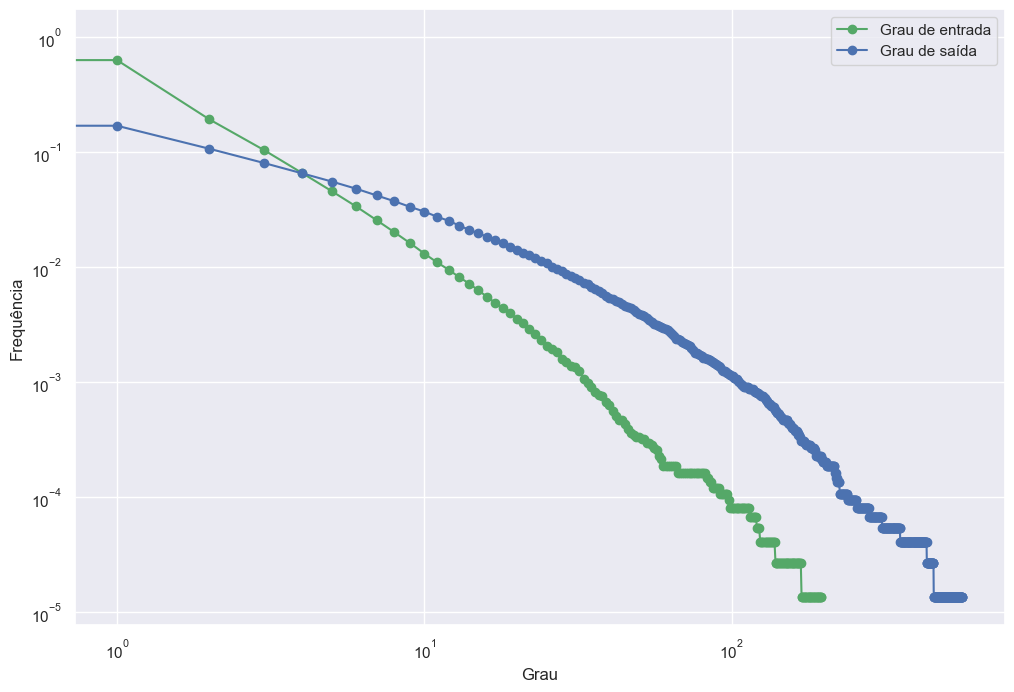

In [90]:
in_degree_freq = degree_histogram_directed(G, in_degree=True)
out_degree_freq = degree_histogram_directed(G, out_degree=True)
# degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='Grau de entrada') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='Grau de saída')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.legend()
plt.show()


In [99]:

# Fit the power law distribution to the in-degree frequencies using numpy
z_in = np.polyfit(np.log(range(1, len(in_degree_freq) + 1)), np.log(in_degree_freq), 1)
p_in = np.poly1d(z_in)

# Fit the power law distribution to the out-degree frequencies using numpy
z_out = np.polyfit(np.log(range(1, len(out_degree_freq) + 1)), np.log(out_degree_freq), 1)
p_out = np.poly1d(z_out)

print(f"In-degree power law (numpy) alpha: {-z_in[0]}, intercept: {z_in[1]}")
print(f"Out-degree power law (numpy) alpha: {-z_out[0]}, intercept: {z_out[1]}")

In-degree power law (numpy) alpha: 2.3319719957867986, intercept: 1.2539997872448245
Out-degree power law (numpy) alpha: 2.1207390259788634, intercept: 2.476994514201272


In [71]:
in_degree_freq = degree_histogram_directed(subG, in_degree=True)
out_degree_freq = degree_histogram_directed(subG, out_degree=True)
degrees = range(len(in_degree_freq))
plt.figure(figsize=(12, 8)) 
plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'go-', label='in-degree') 
plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'bo-', label='out-degree')
plt.xlabel('Grau')
plt.ylabel('Frequência')
plt.show()


NameError: name 'subG' is not defined

In [100]:
degrees = []

for node in G.nodes():
    degrees.append(nx.degree(G, node))

print(f"Nº de nós: {G.number_of_nodes()}")
print(f"Nº de links: {G.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(G)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G)}")
print(f"Cluster médio: {nx.average_clustering(G)}")
# print(f'Coeficiente de assortatividade geral: {nx.degree_assortativity_coefficient(G)}')

# print(f'Coeficiente de centralidade de grau: {nx.degree_centrality(G)}')
# print(f'Coeficiente de centralidade de proximidade: {nx.closeness_centrality(G)}')
# print(f'Coeficiente de centralidade de betweeness: {nx.betweenness_centrality(G)}')

Nº de nós: 74669
Nº de links: 94290
Grau médio: 2.5255460766851034
Densidade: 1.6911836909285794e-05
Cluster global: 0.004703895662064734
Cluster médio: 0.01734227365718946


In [101]:
nx.write_graphml_lxml(G, "E://graph_tcc_correct.graphml")

In [2]:
grafo_tcc = nx.read_graphml("E://graph_tcc_correct.graphml")

In [3]:
import AcessoryMethods as am

acessory = am.AcessoryMethods()

acessory.show_graph_metrics(grafo_tcc)

Nº de nós: 74669
Nº de links: 94290
Grau médio: 2.5255460766851034
Densidade: 1.6911836909285794e-05


In [102]:
# Gerando um subgrafo com o maior componente conexo
componentes = nx.weakly_connected_components(G)
maior_componente = max(componentes, key=len)
G2 = G.subgraph(maior_componente)

In [103]:
degreesSubgraph = []

for node in G2.nodes():
    degreesSubgraph.append(nx.degree(G2, node))

print(f"Nº de nós: {G2.number_of_nodes()}")
print(f"Nº de links: {G2.number_of_edges()}")
print(f"Grau médio: {np.mean(degreesSubgraph)}")
print(f"Densidade: {nx.density(G2)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G2)}")
print(f"Cluster médio: {nx.average_clustering(G2)}")
# print(f'Coeficiente de assortatividade geral: {nx.degree_assortativity_coefficient(subG)}')

# print(f'Coeficiente de centralidade de grau: {nx.degree_centrality(subG)}')
# print(f'Coeficiente de centralidade de proximidade: {nx.closeness_centrality(subG)}')
# print(f'Coeficiente de centralidade de betweeness: {nx.betweenness_centrality(subG)}')

Nº de nós: 46864
Nº de links: 88160
Grau médio: 3.762376237623762
Densidade: 4.014228962746476e-05
Cluster global: 0.004717334267645298
Cluster médio: 0.027410737294196838


In [ ]:
centrality = nx.algorithms.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.girvan_newman(G)

In [ ]:
fluidCommunities = nx.algorithms.community.asyn_fluidc(G, 500)

In [ ]:
centrality = nx.algorithms.degree_centrality(G)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.louvain_communities(G)
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

fig = gv.d3(G, use_node_size_normalization=True, node_size_normalization_max=30,
            use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3,
            zoom_factor=0.6)

fig.savefig(r'E://graph.png')

AttributeError: 'Figure' object has no attribute 'savefig'

In [ ]:
centrality = nx.algorithms.degree_centrality(G2)
nx.set_node_attributes(G, centrality, 'size')

communities = nx.algorithms.community.louvain_communities(G2)
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

fig = gv.d3(G2, use_node_size_normalization=True, node_size_normalization_max=30,
            use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3,
            zoom_factor=0.6)

In [ ]:
fig.display()

In [ ]:
# export the graph as txt
nx.write_edgelist(G, "D:\\Documentos\\data_and_code\\all_data_lisbon\\graphWithCoords.txt", data=False)

In [104]:
# load graph from edgelist txt file
G = nx.read_edgelist("D:\\Documentos\\data_and_code\\all_data_lisbon\\graphWithCoords.txt", create_using=nx.DiGraph())

In [106]:
G = nx.read_graphml("E://graph_tcc_correct.graphml")

In [105]:
pos = nx.spring_layout(G)  # Posições dos nós
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', arrows=True)
plt.savefig("D:\\Documentos\\data_and_code\\all_data_lisbon\\graph.png", dpi=300, bbox_inches='tight')
plt.show()


KeyboardInterrupt: 

In [16]:
def calculateDistance(xP1: float, yP1: float, xP2: float, yP2: float):
    P1 = [float(xP1), float(yP1)]
    P2 = [float(xP2), float(yP2)]
    
    
    
    try:
        return math.dist(P1, P2)
    except TypeError:
        print(f"Erro ao calcular a distância entre os pontos {P1} e {P2}")
        return None

In [17]:
def calculateDistances(graph, generalizationLimit = None):
  nodes_with_median = [node for node in graph.nodes if "median_X" in graph.nodes[node]]
  
  print(f"Existem {len(nodes_with_median)} nós com mediana.")
  
  distances = {}
  
  for node in tqdmBasic(nodes_with_median):
    for other_node in nodes_with_median:
        if node == other_node:
            continue
        
        # print(f"Calculando distância entre {node} e {other_node}")
        
        distance = calculateDistance(
            graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
        )
        if generalizationLimit is not None:
            generaralized_distance = int(distance//generalizationLimit)
            if generaralized_distance not in distances.keys():
                distances[generaralized_distance] = 1
            else:
                distances[generaralized_distance] += 1
        else:
            if distance not in distances.keys():
                distances[distance] = 1
            else:
                distances[distance] += 1
            
        # distancesFromNode[node].append(distance)
  
  
  return distances
  
  # distances = {}
  # for node in tqdmBasic(graph.nodes, total=graph.number_of_nodes()):
  #   if not "median_X" in graph.nodes[node]:
  #     continue

  #   distances[node] = []
  #   for other_node in graph.nodes():
  #     if node == other_node:
  #       continue

  #     if not "median_X" in graph.nodes[other_node]:
  #       continue

  #     distance = calculateDistance(
  #         graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
  #     )

  #     distances[node].append(distance)

  # # Calcula a matriz de distâncias.
  # distance_matrix = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
  # for node in distances:
  #   for other_node in distances[node]:
  #     distance_matrix[node, other_node] = distances[node][other_node]

  # # Ordena a matriz de distâncias.
  # distance_matrix = np.sort(distance_matrix, axis=1)

  # return distance_matrix

In [6]:
# create an empty graph
G = nx.Graph()

# add nodes to the graph
for user in list(df_mean['username']):
    G.add_node(user)

In [8]:
import itertools

# Get all nodes in the graph
nodes = list(G.nodes())

# Add edges between all pairs of nodes
for node1, node2 in tqdmBasic(itertools.combinations(nodes, 2), total=(len(nodes) * (len(nodes) - 1) // 2)):
    G.add_edge(node1, node2)

  0%|          | 10933062/6738037741 [00:15<2:34:48, 724235.73it/s]


KeyboardInterrupt: 

In [9]:
print(list(G.nodes())[:20])


['Manuela_Lagoa', 'oblogdoedinho', 'noventaradio', 'object82', 'Itsmarsousa', 'dezanovept', 'caco_palmela', 'AlexDaSilva', 'gomesduds', 'maumaub', 'HMeMarques', 'MicaelSS', 'lpoeirass', 'akynos', 'Mad7er7', 'k4rdz', 'bh_thamy', 'ricoonn', 'MaurelioFama', 'raquel_cbento']


In [13]:
# add the 'value' attribute to each node
mean_X = dict(zip(df_mean['username'], df_mean['mean_X']))
mean_Y = dict(zip(df_mean['username'], df_mean['mean_Y']))
median_X = dict(zip(df_mean['username'], df_mean['median_X']))
median_Y = dict(zip(df_mean['username'], df_mean['median_Y']))
nx.set_node_attributes(G, mean_X, 'mean_X')
nx.set_node_attributes(G, mean_Y, 'mean_Y')
nx.set_node_attributes(G, median_X, 'median_X')
nx.set_node_attributes(G, median_Y, 'median_Y')
# del mean_X, mean_Y, median_X, median_Y

In [14]:
G2 = G.copy()

nodes_without_attributes = [node for node in G.nodes() if not G.nodes[node]]
G2.remove_nodes_from(nodes_without_attributes)


In [15]:
degreesSubgraph = []

for node in G2.nodes():
    degreesSubgraph.append(nx.degree(G2, node))

print(f"Nº de nós: {G2.number_of_nodes()}")
print(f"Nº de links: {G2.number_of_edges()}")
print(f"Grau médio: {np.mean(degreesSubgraph)}")
print(f"Densidade: {nx.density(G2)}")
# print(f"Distância média: {nx.average_shortest_path_length(G)}")
print(f"Cluster global: {nx.transitivity(G2)}")
print(f"Cluster médio: {nx.average_clustering(G2)}")

Nº de nós: 116087
Nº de links: 50821782
Grau médio: 875.5809349884139
Densidade: 0.007542519640511464


KeyboardInterrupt: 

In [112]:
del mean_X, mean_Y, median_X, median_Y


In [ ]:
for node in G.nodes():
    if 

In [115]:
for node in list(G2.nodes())[:10]:
    print(f"Node {node} has attributes {G2.nodes[node]}")

Node MaurelioFama has attributes {'mean_X': '484771.97087109403', 'mean_Y': '4285817.417282348', 'median_X': '487882.706941838', 'median_Y': '4286391.542569568'}
Node misterteaser has attributes {'mean_X': '470861.9063032128', 'mean_Y': '4304577.4868926825', 'median_X': '464021.4690268664', 'median_Y': '4312727.995991904'}
Node nosuchuser has attributes {'mean_X': '486078.4991715067', 'mean_Y': '4295950.04220583', 'median_X': '486103.60111481865', 'median_Y': '4296493.364874446'}
Node 12Landim has attributes {'mean_X': '491524.37341476994', 'mean_Y': '4299076.471835193', 'median_X': '492320.27642664406', 'median_Y': '4302962.742995066'}
Node dhorta8 has attributes {'mean_X': '486095.67982255213', 'mean_Y': '4286990.380251151', 'median_X': '483945.1292435204', 'median_Y': '4289416.771517939'}
Node GoncaloPCruz has attributes {'mean_X': '487883.63051733957', 'mean_Y': '4286133.087099216', 'median_X': '487745.79216195625', 'median_Y': '4286086.955823366'}
Node BaiaVieira has attributes {'

In [122]:
# iterate over all edges
for u, v in tqdmBasic(G2.edges(), total=G2.number_of_edges()):
    # print(f"Calculando distância entre {u} e {v}")
    # print(f"Coordenadas de {u}: {G.nodes[u]['median_X']}, {G.nodes[u]['median_Y']}")
    # print(f"Coordenadas de {v}: {G.nodes[v]['median_X']}, {G.nodes[v]['median_Y']}")
    # break
    if 'median_X' not in G2.nodes[u] or 'median_X' not in G2.nodes[v]:
        continue
    
    # get the median_X and median_Y of the nodes
    xP1, yP1 = G2.nodes[u]['median_X'], G2.nodes[u]['median_Y']
    xP2, yP2 = G2.nodes[v]['median_X'], G2.nodes[v]['median_Y']
    
    # calculate the distance between the nodes
    distance = calculateDistance(xP1, yP1, xP2, yP2)
    
    # set the edge attribute as the distance
    G2.edges[u, v]['distance'] = distance
    # print(f"Distância entre {u} e {v}: {distance}")
    # break


  0%|          | 0/17069 [00:00<?, ?it/s]

100%|██████████| 17069/17069 [00:00<00:00, 159519.64it/s]


In [147]:
nx.write_graphml_lxml(G2, "E://graphWithDistances.graphml")

In [21]:
del author_id_to_username, fp

In [ ]:
for u, v in G.edges:
    print(G.nodes[u]['median_X'])
    break

In [123]:
distancesToEveryOther = calculateDistances(G)

Existem 32061 nós com mediana.


  1%|          | 195/32061 [00:20<56:19,  9.43it/s]  


KeyboardInterrupt: 

In [29]:
with open("E://distances_to_every_other_node.json", "w") as outfile: 
    json.dump(distancesToEveryOther, outfile)

In [124]:
with open('E://distances_to_every_other_node.json', 'r') as f:
    distancesToEveryOther = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'E://distances_to_every_other_node.json'

In [129]:
# import json

# Read the JSON file
with open('E://distances_to_every_other_node_5m.json', 'r') as f:
    data = json.load(f)

# Create a dictionary from the JSON data
distancesToEveryOther = dict(data)

# Print the dictionary
print(distancesToEveryOther)


{'1483': 169998, '1794': 141696, '1479': 169886, '2107': 141538, '2307': 141614, '1491': 168294, '1503': 168042, '1671': 148290, '2607': 124146, '3237': 111646, '2228': 141616, '1436': 179936, '4333': 87010, '678': 189790, '455': 206644, '2240': 140602, '2065': 138952, '4207': 83334, '1961': 137982, '1407': 182532, '1842': 141688, '2061': 140080, '4784': 79930, '2989': 112676, '1894': 137826, '4299': 86398, '2401': 135520, '2100': 141430, '1718': 143712, '2765': 119090, '1571': 157084, '3376': 108876, '2028': 138146, '1487': 170066, '2541': 125924, '2520': 130262, '1244': 194482, '4304': 86174, '3974': 83816, '8028': 17380, '2329': 139908, '3946': 85488, '1709': 145138, '1456': 172858, '8367': 12696, '1974': 138402, '1862': 140670, '2312': 140514, '5683': 46952, '2317': 141166, '2561': 127846, '3010': 112980, '4656': 86712, '1655': 147436, '2974': 114300, '1546': 158964, '1925': 139494, '2244': 140152, '2051': 138586, '1927': 140024, '2443': 134834, '3027': 112742, '2383': 138898, '313

In [130]:
print(f"{len(distancesToEveryOther):,}")

15,808


In [131]:
print(distancesToEveryOther)

{'1483': 169998, '1794': 141696, '1479': 169886, '2107': 141538, '2307': 141614, '1491': 168294, '1503': 168042, '1671': 148290, '2607': 124146, '3237': 111646, '2228': 141616, '1436': 179936, '4333': 87010, '678': 189790, '455': 206644, '2240': 140602, '2065': 138952, '4207': 83334, '1961': 137982, '1407': 182532, '1842': 141688, '2061': 140080, '4784': 79930, '2989': 112676, '1894': 137826, '4299': 86398, '2401': 135520, '2100': 141430, '1718': 143712, '2765': 119090, '1571': 157084, '3376': 108876, '2028': 138146, '1487': 170066, '2541': 125924, '2520': 130262, '1244': 194482, '4304': 86174, '3974': 83816, '8028': 17380, '2329': 139908, '3946': 85488, '1709': 145138, '1456': 172858, '8367': 12696, '1974': 138402, '1862': 140670, '2312': 140514, '5683': 46952, '2317': 141166, '2561': 127846, '3010': 112980, '4656': 86712, '1655': 147436, '2974': 114300, '1546': 158964, '1925': 139494, '2244': 140152, '2051': 138586, '1927': 140024, '2443': 134834, '3027': 112742, '2383': 138898, '313

In [132]:
distancesToEveryOtherUnique = list(set(distancesToEveryOther))

In [133]:
count = 0
for node in G.nodes():
    if G.nodes[node]:
        count += 1
print(f"Number of nodes with attributes: {count}")


Number of nodes with attributes: 32061


In [134]:
print(G.number_of_nodes())

74669


In [135]:
# gerar um array em P.A.
# [1 - i/n for i in range(0,n)]
# [1 - (i+1)/n for i in range(0,n)]

my_dict = {'a': 3, 'b': 2, 'c': 4}

my_list = [key for key, value in my_dict.items() for _ in range(value)]

print(my_list)


['a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'c']


In [1]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       
    

In [141]:
# extract the distances from the edges
distances = []

for u, v in G2.edges():
    if 'distance' in G2.edges[u, v]:
        distances.append(G2.edges[u, v]['distance'])
        
    

In [142]:
distancesNo0 = [distance for distance in distances if distance != 0.0]
logDistances = [np.log10(distance) for distance in distances]
logDistancesNo0 = [np.log10(x) for x in distancesNo0]


C:\Users\Cliente\AppData\Local\Temp\ipykernel_26776\3683328142.py:2: RuntimeWarning: divide by zero encountered in log10
  logDistances = [np.log10(distance) for distance in distances]


In [145]:
distancesToEveryOtherList = [key for key, value in distancesToEveryOther.items() for _ in range(value)]

MemoryError: 

In [30]:
with open('E://lista_distancias_todos_vértices.json', 'w') as file:
    json.dump(distancesToEveryOtherList, file)


In [7]:
arquivo = load_jsonl('E://lista_distancias_todos_vértices.json')

MemoryError: 

In [4]:
import json

def read_large_json(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            yield json.loads(line)

distancesToEveryOtherList = list(read_large_json('E://lista_distancias_todos_vértices.json'))

MemoryError: 

In [139]:
distancesToEveryOtherList.sort()

NameError: name 'distancesToEveryOtherList' is not defined

In [ ]:
filtered_distances_to_every_other = [distance for _i, distance in tqdmBasic(enumerate(distancesToEveryOtherList), total=805793382) if int(distance) % 1000 == 0]


100%|██████████| 805793382/805793382 [05:19<00:00, 2519328.95it/s]


In [28]:
filtered_distances_to_every_other[len(filtered_distances_to_every_other)-1]

78000.3989097619

In [143]:
filtered_distances = [distance for distance in tqdmBasic(distances) if int(distance) % 1000 == 0]

100%|██████████| 17069/17069 [00:00<00:00, 2438273.11it/s]


In [144]:
prob_all_distances = [1 - (i+1)/len(filtered_distances_to_every_other) for i in tqdmBasic(range(0,len(filtered_distances_to_every_other)))]
prob_connected_distances = [1 - (i+1)/len(filtered_distances) for i in tqdmBasic(range(0,len(filtered_distances)))]

NameError: name 'filtered_distances_to_every_other' is not defined

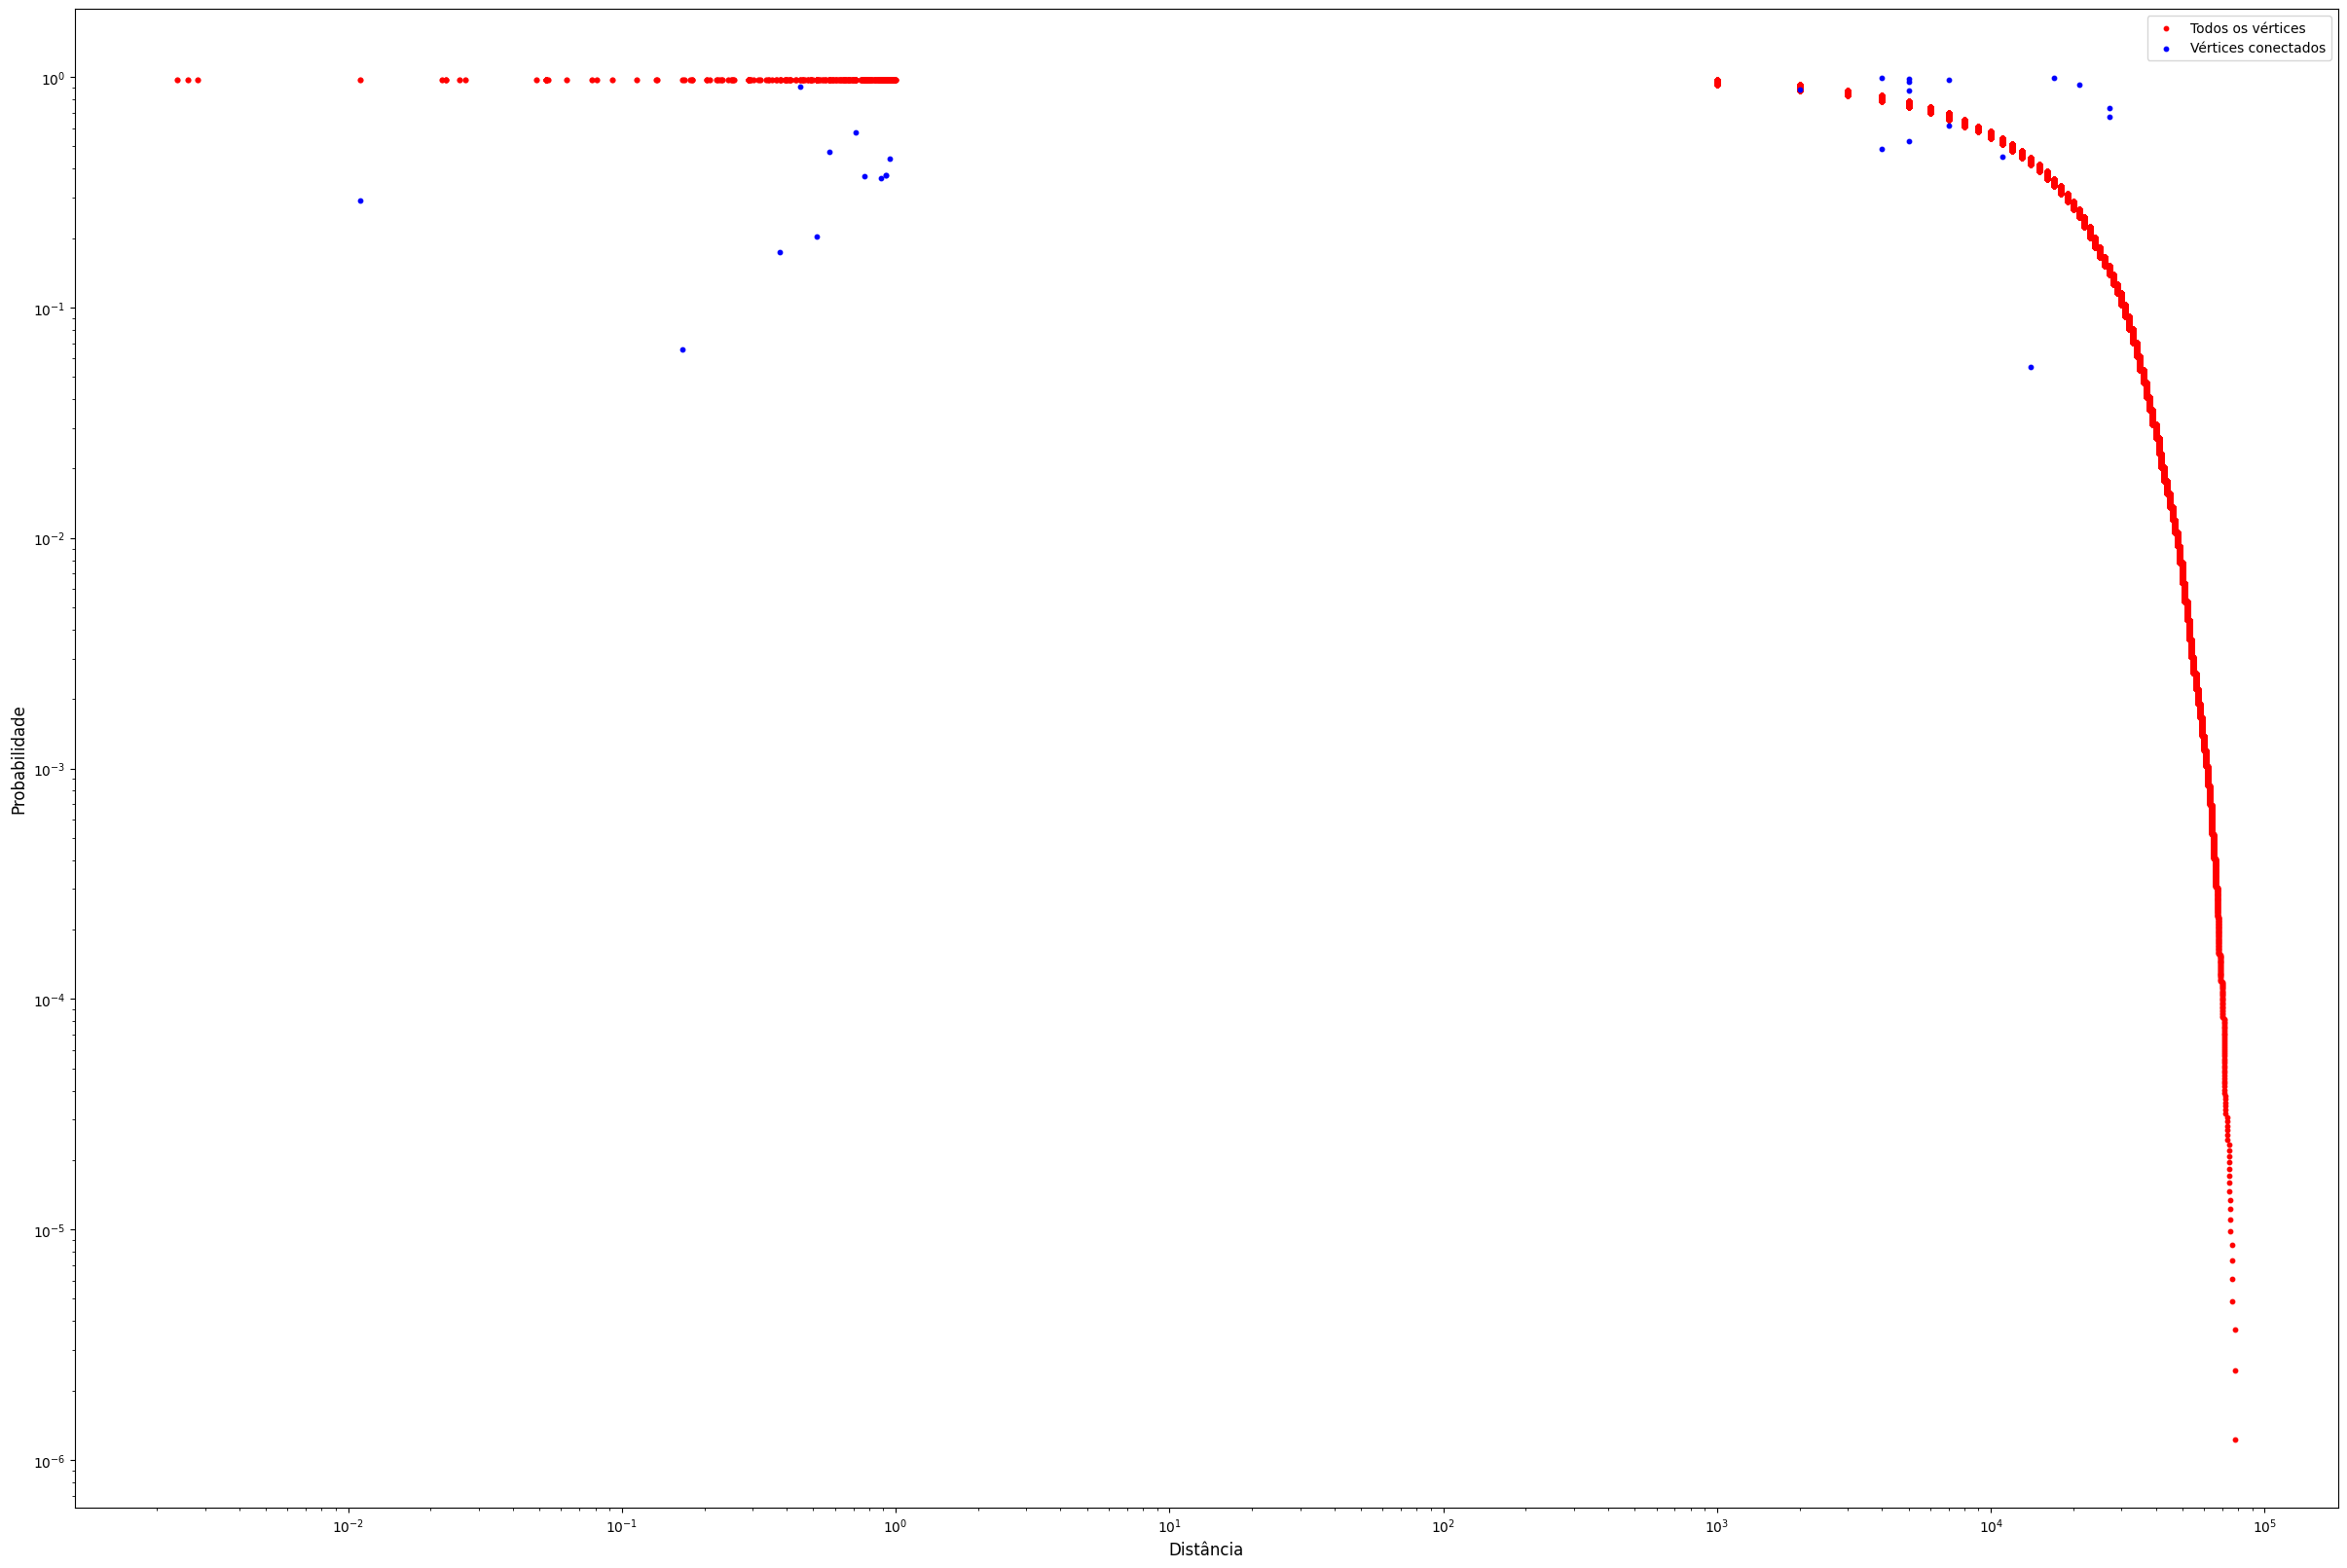

In [45]:
plt.figure(figsize=(30, 20))

# Scatter plot
plt.scatter(filtered_distances_to_every_other, prob_all_distances, label='Todos os vértices', color='red', s=10)
plt.scatter(filtered_distances, prob_connected_distances, label='Vértices conectados', color='blue', s=10)

# Set scale to log
plt.xscale('log')
plt.yscale('log')

# Set labels and title
plt.xlabel('Distância', fontsize=12)
plt.ylabel('Probabilidade', fontsize=12)
plt.legend()

# Show the plot
plt.show()


In [71]:
# plotScatterEmpyricalComplementarDistribution(distances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados .png', show=False)
# plotScatterEmpyricalComplementarDistribution(distancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados sem distância 0.png')
# plotScatterEmpyricalComplementarDistribution(logDistances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log).png')
# plotScatterEmpyricalComplementarDistribution(logDistancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log) sem distância 0.png')
# plotScatterEmpyricalComplementarDistribution(logDistances, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log-log).png', log=True)
# plotScatterEmpyricalComplementarDistribution(logDistancesNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós ligados (log-log) sem distância 0.png', log=True)
plotScatterEmpyricalComplementarDistribution(filtered_distances, output_path='E://', output_file_name='Distribuição de distâncias de nós (10m).png', log=True)
# plotScatterEmpyricalComplementarDistribution(distancesToEveryOtherNo0, output_path='E://', output_file_name='Distribuição de distâncias de nós sem distância 0.png', log=True)

Calculando probabilidade: 100%|██████████| 80624836/80624836 [01:38<00:00, 816403.73it/s]


<class 'list'>


MemoryError: 

In [23]:
distancesToEveryOtherList.sort()

NameError: name 'distancesToEveryOtherList' is not defined

In [37]:
len(filtered_distances)

80579

In [22]:
probabilities = [1 - (i+1)/len(distancesToEveryOtherList) for i in tqdmBasic(range(0,len(distancesToEveryOtherList)))]

NameError: name 'distancesToEveryOtherList' is not defined

In [ ]:
cc = nx.clustering(G)

chave = " "
for k, v in cc.items():
    if chave == " ":
        chave = k
    if v > cc[chave]:
        chave = k
        
print(chave, cc[chave])

In [ ]:
print(len(Y))

In [ ]:
print(max(nodeClusterCoef))

In [2]:
G = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_com_coordenadas.graphml")

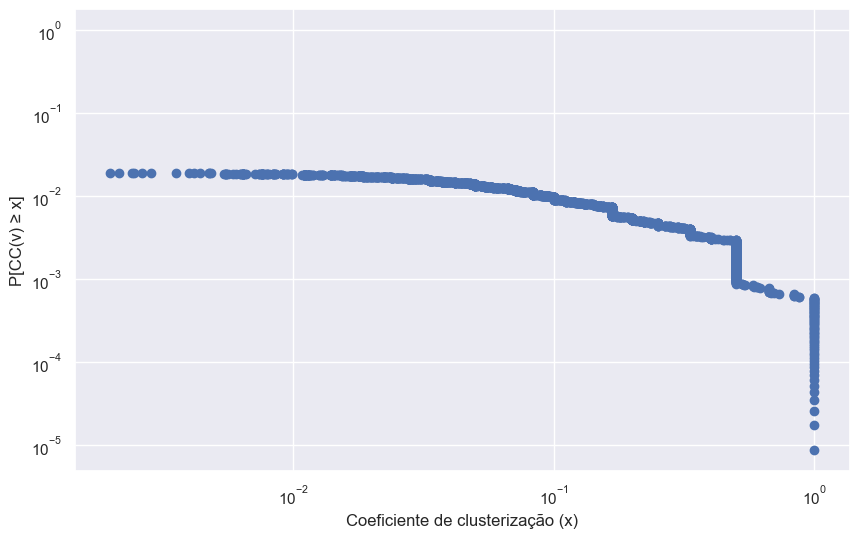

In [7]:
# Calculate the clustering coefficient for each node
clustering_coeffs = nx.clustering(G)

# Get the values of the clustering coefficients
cc_values = list(clustering_coeffs.values())

# Sort the values in ascending order
cc_values.sort()

# Calculate the CCDF
ccdf = [1 - (i / len(cc_values)) for i in range(len(cc_values))]

# Plot the CCDF
plt.figure(figsize=(10, 6))
plt.plot(cc_values, ccdf, marker='o', linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coeficiente de clusterização (x)')
plt.ylabel('P[CC(v) ≥ x]')
# plt.title('CCDF of Clustering Coefficient')
plt.grid(True)
plt.show()

In [8]:
import csv

# Define the file path
file_path = "D:\\Documentos\\data_and_code\\all_data_lisbon\\clusterring_coefficients.csv"

# Write the clustering coefficients to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Node", "Clustering Coefficient"])
    for node, coeff in clustering_coeffs.items():
        writer.writerow([node, coeff])

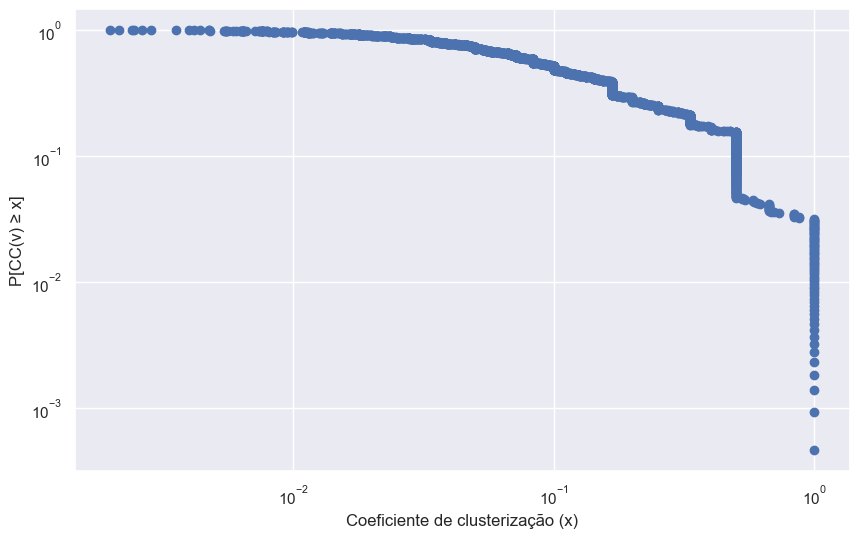

In [5]:
# Calculate the clustering coefficient for each node
clustering_coeffs = nx.clustering(G)
clustering_coeffs = {k: v for k, v in clustering_coeffs.items() if v != 0}
# Get the values of the clustering coefficients
cc_values = list(clustering_coeffs.values())

# Sort the values in ascending order
cc_values.sort()

# Calculate the CCDF
ccdf = [1 - (i / len(cc_values)) for i in range(len(cc_values))]

# Plot the CCDF
plt.figure(figsize=(10, 6))
plt.plot(cc_values, ccdf, marker='o', linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Coeficiente de clusterização (x)')
plt.ylabel('P[CC(v) ≥ x]')
# plt.title('CCDF of Clustering Coefficient')
plt.grid(True)
plt.show()

Coeficientes de clusterização: [0, 0, 0, 0, 0, 0, 0, 0, 0.03803418803418803, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0.02892030848329049, 0, 0.1, 0.016595649248710473, 0.05238095238095238, 0.05555555555555555, 0, 0, 0, 0, 0.2222222222222222, 0, 0.047619047619047616, 0, 0, 0.5, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0380952380952381, 0.02005730659025788, 0.07142857142857142, 0.032148900169204735, 0.04523809523809524, 0.06951871657754011, 0.019230769230769232, 0, 0.017079419299743808, 0.08333333333333333, 0.07407407407407407, 0.05357142857142857, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.023809523809523808, 0.09433962264150944, 1.0, 0.11481481481481481, 0.3333333333333333, 0, 0.2, 0.3888888888888889, 0.16666666666666666, 0.25, 0, 0, 0, 0.0365025466893039, 0.08333333333333333, 0.5, 1.0, 0.16071428571428573, 1.0, 0.07692307692307693, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011363636363636364, 0, 0, 0, 0, 0, 0, 

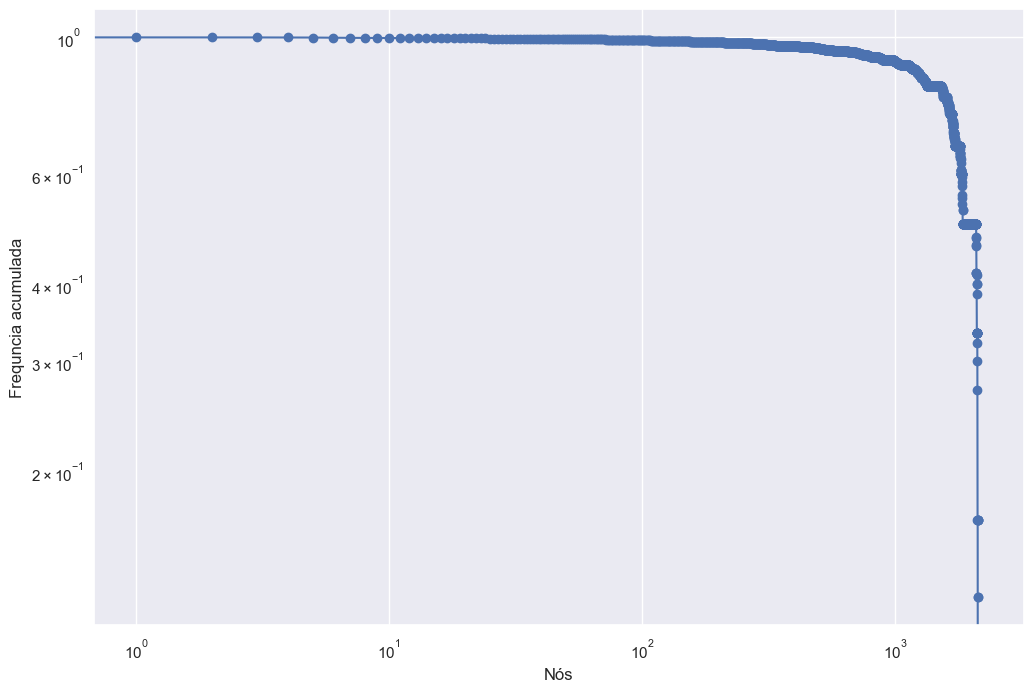

In [45]:
# Create a log-log histogram of the cumulative frequency of the local clustering coefficient of the nodes of the graph
nodeClusterCoef = list(nx.clustering(G).values())
print(f"Coeficientes de clusterização: {nodeClusterCoef}")
nodeClusterCoef = [i for i in nodeClusterCoef if i != 0]
# nodeClusterCoef = [float(i)/maxcluster for i in tqdmBasic(nodeClusterCoef)]
print(f"Coeficientes de clusterização normalizados: {nodeClusterCoef}")
# hist, bins = np.histogram(nodeClusterCoef, bins=100)
nodeClusterCoef.sort()
print(f"Coeficientes de clusterização ordenados: {nodeClusterCoef}")
# cumulativeFreq = np.cumsum(hist)
# maxCumulativeFreq = max(cumulativeFreq)


# ----------------------------------------------------------------
# dmax = max(degseq) + 1
# freq = [0 for d in range(dmax)]
# for d in degseq:
#     freq[d] += 1

# # Normalize the frequency to go from 0 to 1
# total = sum(freq)
# normalized_freq = [f / total for f in freq]

# # Make the histogram accumulative from highest to lowest
# accumulative_freq = [sum(normalized_freq[i:]) for i in range(len(normalized_freq))]

# inverseCumulativeFreq = [ maxCumulativeFreq - i for i in cumulativeFreq]
# ----------------------------------------------------------------

maxFreq = nodeClusterCoef[-1]
print(f"Maior frequência: {maxFreq}")
inverseCumulativeFreq = [maxFreq - i for i in nodeClusterCoef]



plt.figure(figsize=(12, 8))
# plt.plot(range(len(inverseCumulativeFreq)), inverseCumulativeFreq, 'bo-')
plt.loglog(range(len(inverseCumulativeFreq)), inverseCumulativeFreq, 'bo-')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Nós')
plt.ylabel('Frequncia acumulada')
plt.show()

# Y = np.linspace(len(nodeClusterCoef), 1, num=len(nodeClusterCoef))
# X = nodeClusterCoef

# plt.figure(figsize=(12, 8))
# # plt.plot(np.log(X), np.log(Y), 'bo-')
# # plt.plot(X, Y, 'bo-')
# plt.loglog(X, Y, 'bo-')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Coeficiente de clusterização')
# plt.ylabel('Frequncia acumulada')
# plt.show()

In [ ]:
print(nodeClusterCoefSubGrafo)

In [ ]:
nodeClusterCoefSubGrafo = list(nx.clustering(G2).values())
# hist, bins = np.histogram(nodeClusterCoef, bins=100)
# cumulativeFreq = np.cumsum(hist)

# inverseCumulativeFreq = [ maxCumulativeFreq - i for i in cumulativeFreq]


# plt.figure(figsize=(12, 8))
# plt.loglog(bins[:-1], inverseCumulativeFreq, 'go-')
# plt.xlabel('Clustering coefficient')
# plt.ylabel('Cumulative frequency')
# plt.show()

In [41]:
import AcessoryMethods as am

acessory = am.AcessoryMethods()
acessory.show_graph_metrics(G, True)

Nº de nós: 116087
Nº de links: 20035
Grau médio: 0.34517215536623397
Densidade: 1.486708799365272e-06
Cluster global: 0.032107423879575776
Cluster médio: 0.0035780833649532847


C:\Users\Cliente\AppData\Local\Temp\ipykernel_15172\1983437995.py:9: RuntimeWarning: divide by zero encountered in log
  logDegrees.append(np.log(nx.degree(G, node)))


amount of clustering coefficients: 116087
Degrees: 116087
Log degrees: 116087


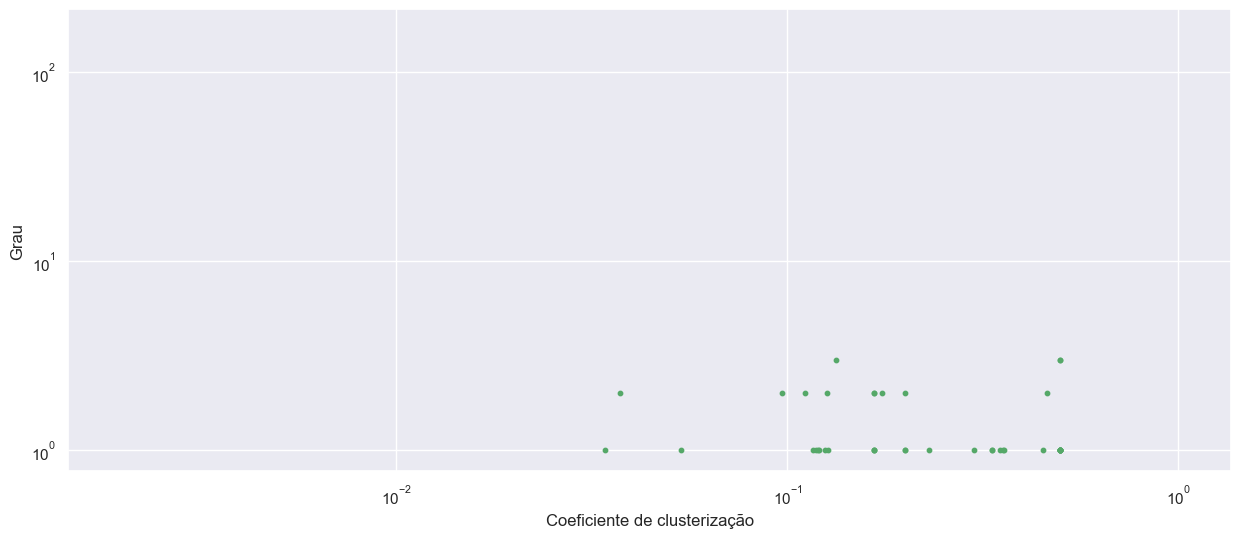

In [43]:
# draw a scatter plot of the degree of the nodes of the graph versus their local clustering coefficient
degrees = []
logDegrees = []

for node in G.nodes():
    degrees.append(nx.degree(G, node))
    
for node in G.nodes():
    logDegrees.append(np.log(nx.degree(G, node)))
    
print(f"amount of clustering coefficients: {len(nodeClusterCoef)}")
print(f"Degrees: {len(degrees)}")
print(f"Log degrees: {len(logDegrees)}")
    
fig = plt.figure(figsize=(15, 6))

ax = fig.add_gridspec(1, 1)
    
# ax1 = fig.add_subplot(ax[0, 0])
# plt.scatter(nodeClusterCoef, degrees, s=10, c='g')
# plt.ylabel('Grau')
# plt.xlabel('Coeficiente de clusterização')

ax2 = fig.add_subplot(ax[0, 0])
plt.scatter(nodeClusterCoef, degrees, s=10, c='g')
plt.ylabel('Grau')
plt.xlabel('Coeficiente de clusterização')
ax2.set_xscale('log')
ax2.set_yscale('log')

# ax3 = fig.add_subplot(ax[0, 2])
# plt.scatter(np.log(nodeClusterCoef), logDegrees, s=10, c='g')
# plt.ylabel('Log grau')
# plt.xlabel('Log clustering coefficient')
# plt.show()

In [ ]:
degreesSubg = []
logDegreesSubg = []

for node in G2.nodes():
    degreesSubg.append((nx.degree(G2, node)))
    
for node in G2.nodes():
    logDegreesSubg.append(np.log(nx.degree(G2, node)))

fig = plt.figure(figsize=(30, 8))

ax = fig.add_gridspec(1, 3)    

ax1 = fig.add_subplot(ax[0, 0])
plt.scatter((nodeClusterCoefSubGrafo), degreesSubg, s=10, c='g')
plt.ylabel('Grau')
plt.xlabel('Clustering coefficient')

ax2 = fig.add_subplot(ax[0, 1])
plt.scatter((nodeClusterCoefSubGrafo), logDegreesSubg, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Clustering coefficient')

ax3 = fig.add_subplot(ax[0, 2])
plt.scatter(np.log(nodeClusterCoefSubGrafo), logDegreesSubg, s=10, c='g')
plt.ylabel('Log grau')
plt.xlabel('Log clustering coefficient')

plt.show()

In [ ]:
plt.savefig("D:\\Documentos\\data_and_code\\all_data_lisbon\\plot_degree_clustering.png", dpi=300)


In [ ]:
usuarioUnicos = dfMencoes['author_id'].unique()

In [1]:
# Desenhe o grafo
pos = nx.spring_layout(G2)
nx.draw_networkx_nodes(G2, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G2, pos)
nx.draw_networkx_edges(G2, pos, edge_color='r', arrows=True)
nx.draw_networkx_edges(G2, pos, arrows=False)
plt.show()

NameError: name 'nx' is not defined

In [ ]:
seed = 13648  # Seed random number generators for reproducibility
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [ ]:
dictUsuarios = {}
cont = 0
for user in usuarioUnicos:
    cont += 1
    dictUsuarios[user] = dfMencoes.loc[dfMencoes['author_id'] == user]['usuario'].values[0]
    print(cont)
    

In [ ]:
dictUsuarios

In [ ]:
i = 1
for index, row in dfMencoes.iterrows():
    clear_output(wait=True)
    display('Iteration '+str(i)+' of '+str(dfMencoes.shape[0]))
    dfMencoes['usuario'] = dictUsuarios[row['author_id']]
    i += 1

In [ ]:
dfMencoes.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentionsWithUserNames.jsonl', orient='records', lines=True)

In [ ]:
dfMencoesComUserName.to_json(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\mentionsWithUserNames.jsonl', orient='records', lines=True)

In [ ]:
dataFrameComUsernames.to_json(r'E:\\data_com_usernames_30k.jsonl', orient='records', lines=True)

In [ ]:
teste1 = data_frame['entities_mentions']
teste1.dropna(inplace=True)
# teste1.reset_index(drop=True, inplace=True)
teste1 = teste1.to_frame()
teste1


In [ ]:
# print(mention['username'] for mention in teste1.at[0])
# print(data['entities_mentions'].at[2350])
# print(teste1.at[2350])

mentionsUsuario = {}

# Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
    
contador = 1
for mention in teste1.itertuples():
    print(f"Mention {contador} de {teste1.shape[0]}")
    
    usuariosMencionados = []
    if data_frame['author_id'].at[mention.Index] not in mentionsUsuario:
        mentionsUsuario[data_frame['author_id'].at[mention.Index]] = []
        
    for usuario in mention[1]:
        usuariosMencionados.append(usuario['username'])
        # print(usuario['username'])
        mentionsUsuario[data_frame['author_id'].at[mention.Index]].extend(usuariosMencionados)
    contador += 1

In [ ]:
# para cada lista de usuários mencionados, remover os usuários repetidos
mentionsUsuario = {k: list(dict.fromkeys(v)) for k, v in mentionsUsuario.items()}

print(mentionsUsuario)

In [ ]:
len(mentionsUsuario)

In [ ]:
mentionsUnicas = geraDictMentionsByUser(data_frame)
mentionsNaoUnicas = geraDictMentionsByUser(data_frame, False)

In [ ]:
print(f"Média das mentions sem usuário repetido: {returnMediaDictListas(mentionsUnicas)}")
print(f"Média das mentions com usuário repetido: {returnMediaDictListas(mentionsNaoUnicas)}")

In [ ]:
idsPerfisUnicos : list
mentions: list
usuariosMencionados: list
tweetsComLinkEncurtado: list

# Recuperando uma lista com os valores únicos da coluna author_id
idsPerfisUnicos = data_frame['author_id'].unique().tolist()

# Recuperando uma lista com os valores não-nulos da coluna entities_mentions
# mentions = data['entities_mentions']
# mentions.dropna(inplace=True)
# mentions.reset_index(drop=True, inplace=True)

# # Recuperando uma lista com os valores não-nulos e únicos das mentions
# usersMencionados = [user for user in mentions[0].at[0] if user['username'] not in usersMencionados]

# # Recuperando uma lista com os valores não-nulos e únicos da coluna entities_annotations
# annotationsUnicas = data['context_annotations'].dropna().unique()


In [ ]:
mencoesSet = set()

for lista in mentionsUnicas.values():
    mencoesSet.update(lista)
    
usuariosMencionados = list(mencoesSet)

In [ ]:
print(f'Quantidade de perfis únicos: {len(idsPerfisUnicos)}')
print(f'Quantidade de perfis mencionados: {len(usuariosMencionados)}')

In [ ]:
dfExportUsuariosMencionados = pd.DataFrame(usuariosMencionados, columns=['username'])
dfExportUsuariosMencionados.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\usuariosMencionados.csv', index=False)

In [ ]:
teste2 = data_frame['entities_annotations']
teste2.dropna(inplace=True)
teste2.to_frame()

teste2.shape[0]

In [ ]:
teste2.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\teste2.csv', index=False)

In [24]:
df_mean = df_mean.drop(index=0)

df_mean.head()

username            mean_lat            mean_lon   median_lat  \
1  Manuela_Lagoa                38.7         -9.18333333         38.7   
2  oblogdoedinho   38.72556305044776  -9.150001534925371  38.72556305   
3   noventaradio   38.86226743322353  -9.065096915696257  38.86485962   
4       object82   38.75138141069397  -9.188555476450512      38.7167   
5    Itsmarsousa  38.650378758920446  -9.074262791420454     38.66137   

    median_lon              mean_X             mean_Y            median_X  \
1  -9.18333333   484058.0201695964  4283502.065548434   484058.0201695964   
2  -9.15000153   486961.0744357934  4286333.415443861   486961.0748638524   
3  -9.06072863  494352.23164528405  4301494.446264396   494731.4127623029   
4      -9.1569  483615.65982184716  4289204.575585471   486359.7383995273   
5     -9.07744   493537.9279843213  4277982.518656515  493262.48875507596   

            median_Y  
1  4283502.065548434  
2  4286333.415393474  
3  4301781.836199852  
4  4285350.924191058  
5  4279202.385287764

In [8]:
X=df_mean.loc[:,['username','median_lat','median_lon']]
X.head(10)

username   median_lat   median_lon
0  Manuela_Lagoa         38.7  -9.18333333
1  oblogdoedinho  38.72556305  -9.15000153
2   noventaradio  38.86485962  -9.06072863
3       object82      38.7167      -9.1569
4    Itsmarsousa     38.66137     -9.07744
5     dezanovept      38.7128  -9.14637322
6   caco_palmela  38.57453305  -8.94689441
7    AlexDaSilva  38.73843828     -9.17067
8      gomesduds      38.7261  -9.15913394
9        maumaub   38.7019934   -9.3454893

In [9]:
print(X.dtypes)


username      object
median_lat    object
median_lon    object
dtype: object


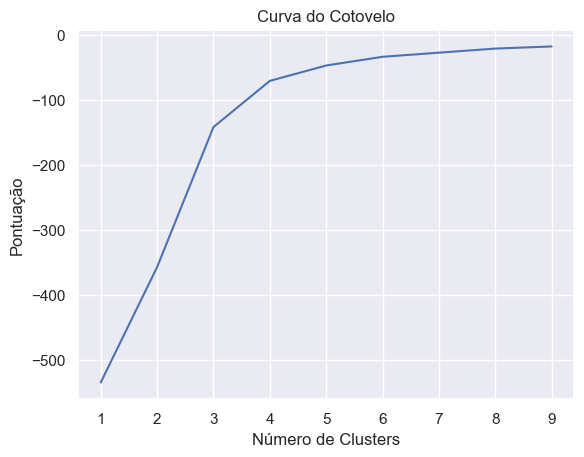

In [10]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = X[['median_lat']]
X_axis = X[['median_lon']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

#Visualize
plt.plot(K_clusters, score)
plt.xlabel('Número de Clusters')
plt.ylabel('Pontuação')
plt.title('Curva do Cotovelo')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

X.head(10)

username   median_lat   median_lon  cluster_label
0  Manuela_Lagoa         38.7  -9.18333333              1
1  oblogdoedinho  38.72556305  -9.15000153              1
2   noventaradio  38.86485962  -9.06072863              0
3       object82      38.7167      -9.1569              1
4    Itsmarsousa     38.66137     -9.07744              1
5     dezanovept      38.7128  -9.14637322              1
6   caco_palmela  38.57453305  -8.94689441              3
7    AlexDaSilva  38.73843828     -9.17067              1
8      gomesduds      38.7261  -9.15913394              1
9        maumaub   38.7019934   -9.3454893              2

In [13]:
X.to_csv(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\usuariosComClusters.csv', index=False)

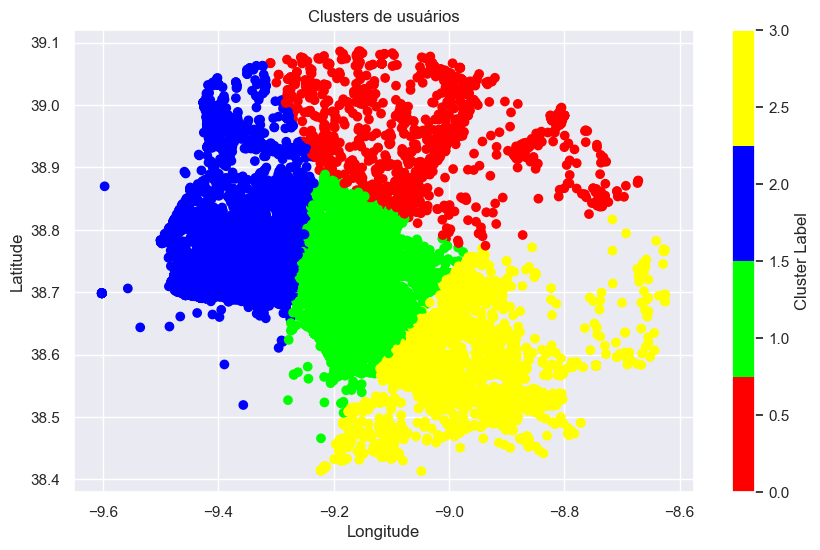

In [24]:
from matplotlib.colors import ListedColormap

# Define a discrete color ramp
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FFFF00'])

x = [float(X['median_lon'][i]) for i in range(len(X))]
y = [float(X['median_lat'][i]) for i in range(len(X))]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=X['cluster_label'], cmap=cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters de usuários')
plt.colorbar(label='Cluster Label')
plt.show()

In [19]:
import geopandas as gpd
from libpysal.weights import Rook

# Carregue o shapefile
gdf = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Seccao_Area_de_Interesse.shp")

# Crie a matriz de adjacências usando o método Queen de libpysal
w = Rook.from_dataframe(gdf)

# A matriz de adjacências completa é obtida com w.full()
full_matrix, ids = w.full()

# A matriz de adjacências completa é armazenada em full_matrix
# Os IDs dos polígonos são armazenados em ids

C:\Users\Cliente\AppData\Local\Temp\ipykernel_19032\2648537907.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Rook.from_dataframe(gdf)


In [20]:
import pandas as pd

# Convert the matrix to a DataFrame
df_matrix = pd.DataFrame(full_matrix)
 

# Export the DataFrame to a CSV file
df_matrix.to_csv(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\matrix_seccao_rook", index=False)


In [23]:
# Replace ids with corresponding line in column OBJECTID
ids = [gdf['DTMNFRSEC2'].iloc[i] for i in ids]
# gdf['OBJECTID'].iloc[0]

In [24]:
with open(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\ids_matrix_seccao_rook.csv", "w") as f:
    f.write("")

<Axes: >

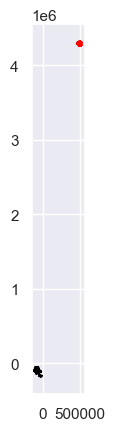

In [48]:
import numpy as np

# Get the number of polygons in gdf
num_polygons = len(gdf)

# Initialize an empty matrix
flow_matrix = np.zeros((num_polygons, num_polygons))

# Iterate over the edges in G2
for source, target in G2.edges:
    # Check if the source and target nodes are polygons in gdf
    if source in gdf['DTMNFRSEC2'].values and target in gdf['DTMNFRSEC2'].values:
        # Get the indices of the source and target polygons in gdf
        source_idx = gdf.index[gdf['DTMNFRSEC2'] == source].tolist()[0]
        target_idx = gdf.index[gdf['DTMNFRSEC2'] == target].tolist()[0]
        
        # Increment the corresponding cell in the matrix
        flow_matrix[source_idx, target_idx] += 1

# Return the flow matrix
flow_matrix
